# Hate Speech - Descriptive Analysis


### Table of Contents - 1
[1. Data, Preprocessing, and Annotation (4 pts)](#data)    
[1.1. Briefly describe the content and type of the data set, and what you are planning to look at](#des)  
[1.2. Preprocess the data and explain which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing](#prep)  
[1.3. Split the data into dedicated training, development, and test sets](#split)  
[2. Research Question(s) (2 pts)](#res)  
[3. Analysis (6 pts)](#anal)  
[3.1. Topic modeling with LDA (3 pts) ](#lda)  
[3.1.1. LDA + Dependent Variable](#lda2)  
[3.1.2 LDA with only negative comments](#lda3)  
[3.2. Dense word embeddings or document embeddings: visualize these and show a clustering (3 pts)](#doc)  
[3.2.1. Docs Embeddings](#doc1)  
[3.2.2. Dimensionality Reduction SVD](#doc2)   
[3.2.3. KMeans Clustering](#doc3)     
[3.3. Other methods](#other)    
[3.3.1. TFIDF](#tfidf)    
[3.3.2. NER](#ner)  

In [6]:
import numpy as np
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm')

import re
import os 
import random
import time

import nltk 
from nltk import SnowballStemmer
stemmer = SnowballStemmer('english')
from collections import defaultdict
from collections import Counter

from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary

from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION
from gensim.models import Doc2Vec
from gensim.models.doc2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument

from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import multiprocessing 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from matplotlib import gridspec
import seaborn as sns
sns.set_style("dark")

b_dir =os.getcwd()


## 1. Data, Preprocessing, and Annotation (4 pts)
<a id="data"></a>

**Dataset:** TOXIC COMMENTS "train.csv"
### 1.1. Briefly describe the content and type of the data set, and what you are planning to look at. (100 w)
<a id="des"></a>
The train.csv file is a dataset of 159K toxic comments from Wikipedia's talk page edits. These comments have been labeled by human raters for toxic behavior. There are 6 different shades of toxicity:
1. toxic
2. severe_toxic
3. obscene
4. threat
5. insult
6. identity_hate

Each toxic label is expressed with a dummy variable; there are 2 more variables: the id of each commentator and the comment text. The idea is to build a model to predict the probability of each type of toxicity for each comment.

*Disclaimer: the dataset contains text that may be considered profane, vulgar, or offensive.*

In [2]:
# Importing raw data
data = pd.read_csv(os.path.join(b_dir,'train.csv'),encoding='utf-8')
docs_pre = len(data)
print("Total number of documents BEFORE preprocessing: {}".format(docs_pre))
data.head()

Total number of documents BEFORE preprocessing: 159571


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### 1.2. Preprocess the data and explain which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing. (200 w)
<a id="prep"></a>
Preprocessing steps: 
1. **Clean comments:** Using Regular Expression, comments have been cleaned from symbols, links, user names, numbers and punctuations, because they are not interesting for our analysis;


2. **Expand contractions:** All most common english abbreviations have been expanded; however comments with contractions have been kept in a separate column because they may be indicative for the prediction task;


3. **Reduce noise:** Tokens, lemmas and stems have been derived for comments with contractions and without; two lemmatizations have been performed: one more "strong", keeping only tokens of content words, another more "soft", keeping also tokens of some function words because if people have individual patterns for using them, they may give some interesting insights; 



4. **Creating new labels:** Each comment may have more than 1 toxic label. Therefore, to reduce variance and get a more rebust predictor, we made a new classification without overlaps. Since some label classes have a few observations, we labelled osservations that have multiple labels, with the label of the smallest class they belong to. Firstly, we had a look at intersections between labels. Then according to this rule, we assigned 2 new labels and stored them in these 2 columns:
    1. **Classe:** categorical variable, whose value depends on the ones present in ***toxic, severe_toxic, obscene,	threat,	insult, identity_hate*** category columns. Given an observation with "1" in more than one of these categories, we decided to label that observation with the name of the smallest category (e.g. observation 0 can be labeled with "toxic" and "threat" values, since threat class is smaller, the value of "classe" for this observation is "threat"). The reason of this semplification is to get a more balanced dataset. 
    2. **Negative:** binary variable, 1 if "classe" is toxic, any level of toxicity, 0 if it's "notoxic".    

Classe column contain hence 7 new categories: notoxic, toxic, insult, severe, obscene, hate, threat. Therefore, after these two steps, we've created 7 new dummy variables per each new category. 


Statistics about docs, tokens and types: 

|           | BEFORE Preprocessing | AFTER Preprocessing (Expanded) | AFTER Preprocessing (Contractions) |
| --------- | --------------------| -------------------- |------------|
| **Num Docs**  | 159,571 | 158,317|158,317 |
| **Num Tokens**|  13,335,590 | 4,640,420|4,691,789|
| **Num Types** | 264,861 |185,171|185,177 |

*The code above, between "#####” lines, is the preprocessing, since it's very slow, we saved the result in a csv and uploaded it directly at the end of* [*this paragraph.*](#upload)

######################################################################################################################

In [7]:
text = data.comment_text.apply(str).tolist()
tokens_pre = [token.text for sentence in text for token in nlp(sentence)]
toks_pre = len(tokens_pre)
vocab_pre = sorted(set(tokens_pre))
typ_pre = len(vocab_pre)
print("Total number of tokens BEFORE preprocessing: {}".format(toks_pre))
print("Total number of types BEFORE preprocessing: {}".format(typ_pre))

Total number of tokens BEFORE preprocessing: 13335590
Total number of types BEFORE preprocessing: 264861


In [4]:
'''
Creating a dictionary with the most frequent english contractions from 
https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
''' 

contraction_dict = {"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have",
                    "couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not",
                    "hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he would",
                    "he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is","how'd": "how did","how'd'y": "how do you",
                    "how'll": "how will","how's": "how is","i'd": "i would","i'd've": "i would have","i'll": "i will","i'll've": "i will have",
                    "i'm": "i am","i've": "i have","isn't": "is not","it'd": "it had","it'd've": "it would have","it'll": "it will",
                    "it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have",
                    "mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have",
                    "needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have",
                    "shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will",
                    "she'll've": "she will have","she's": "she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have",
                    "so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had",
                    "there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will",
                    "they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had",
                    "we'd've": "we would have","we'll": "we will","we'll've": "we will have", "we're": "we are","we've": "we have",
                    "weren't": "were not","what'll": "what will","what'll've": "what will have","what're": "what are","what's": "what is",
                    "what've": "what have","when's": "when is","when've": "when have","where'd": "where did","where's": "where is","where've": "where have",
                    "who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have",
                    "will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have",
                    "y'all": "you all","y'alls": "you alls","y'all'd": "you all would","y'all'd've": "you all would have", "y'all're": "you all are",
                    "y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have",
                    "you're": "you are","you've": "you have"}

contr = re.compile('(%s)' % '|'.join(contraction_dict.keys()))

def expandContractions(text, contr=contr):
    '''
    Aim: Expanding contractions in text (list of sentences as input, returns list of expanded sentences) 
    '''
    l = []
    for sentence in text:
        def replace(match):
            return contraction_dict[match.group(0)]
        sent = contr.sub(replace, sentence)
        l.append(sent)
    return l

In [5]:
 def clean(dataframe, column:str):
    '''
    Aim: clean data and lower case text
    '''
    df = dataframe.copy()
    df[column] = df[column].apply(lambda x: x.lower()) # lower case every comment  
    df[column] = df[column].apply(lambda x: str(x)) #ensure they are strings
    df[column] = df[column].str.replace(r"(@[A-Za-z0-9_]+)|([\n]+)",'', regex=True) # remove any username in the comments
    df[column] = df[column].str.replace("\[\[user.*",'',regex=True)  # remove any text starting with User 
    df[column] = df[column].str.replace("(\w+:\/\/\S+)", '', regex=True) # remove links 
    df[column] = df[column].str.replace("(http://.*?\s)|(http://.*)",'',regex=True) #remove http links in the text
    df[column] = df[column].str.replace(r"[^\w\s]",' ', regex=True) # remove punctuation
    df[column] = df[column].str.replace(r"[0-9]+", '', regex=True) # no numbers
    df[column] = df[column].str.replace(r"\s[\s]+", ' ', regex=True) # no more than two white spaces
    df[column] = df[column].str.replace(r"^[\s]+", '', regex=True) #no white spaces at the beginning

    df = df.drop_duplicates([column]) # retreive unique comments
    df = df.dropna() # removing missing values  
    return df 

In [6]:
def preproc(df, column:str, contract=True):
    '''
    Aim: Lemmatization, Tokenization, Stemming
    '''
    documents = df[column].tolist()
    tokens=[]
    stems=[]
    lemmas2=[]
    lemmas=[]
    i=0
    for sentence in documents:
        tokens.append([])
        stems.append([])
        lemmas2.append([])
        lemmas.append([])
        for token in nlp(sentence):
            if not token.is_stop and len(token.text)>2:
                tokens[i].append(token.text)
                stems[i].append(stemmer.stem(token.text))
                if token.pos_ in {'NOUN', 'VERB','PROPN','ADJ','ADV','INTJ','ADP','AUX','CCONJ','SCONJ','PRON','DET'}:
                    lemmas2[i].append(token.lemma_)
                    if token.pos_ in {'NOUN', 'VERB', 'PROPN', 'ADJ', 'ADV'}:
                        lemmas[i].append(token.lemma_)
        i+=1

    print("tokenization ok!")
    print("stemmatization ok!")
    print("lemmatization content words ok!")
    print("lemmatization function words ok!")

    stem_origins = defaultdict(lambda: defaultdict(int))
    for sentence in tokens:
        for token in sentence:
            stem = stemmer.stem(token)
            stem_origins[stem][token.lower()] += 1
    
    if contract: 
        df["tokens_con"] = [' '.join([i for i in l]) for l in tokens]
        df["lemmas_con"] = [' '.join([i for i in l]) for l in lemmas]
        df["stems_con"] = [' '.join([i for i in l]) for l in stems]
        df["lemmas_fw_con"] = [' '.join([i for i in l]) for l in lemmas2]
    else: 
        df["tokens_ex"] = [' '.join([i for i in l]) for l in tokens]
        df["lemmas_ex"] = [' '.join([i for i in l]) for l in lemmas]
        df["stems_ex"] = [' '.join([i for i in l]) for l in stems]
        df["lemmas_fw_ex"] = [' '.join([i for i in l]) for l in lemmas2]
        
    return tokens, stems, lemmas, lemmas2, stem_origins

In [7]:
# Expand contractions
data['txt_expanded'] = expandContractions(data['comment_text'].apply(lambda x: x.lower()).to_list()) 
data.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,txt_expanded
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation\nwhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww! he matches this background colour i am ...


In [8]:
# Clean data
data = clean(data, "comment_text")
data = clean(data, "txt_expanded")
data = data.rename(columns={"comment_text":"txt_contract"})

In [9]:
# How many abbreviated sentences? 
one = data.txt_contract.tolist()
two = data.txt_expanded.tolist()
abb = sum(1 for i in range(len(one)) if one[i] != two[i])
print("Total number of docs with abbreviations: {}".format(abb))

Total number of docs with abbreviations: 63144


In [10]:
# Preprocessing with expanded contractions (list of lists)
tokens, stems, lemmas, lemmas2, stem_origins = preproc(data, "txt_expanded", contract=False)
tokens = [w for i in range(len(tokens)) for w in tokens[i]]
toks_pos_e = len(tokens)
vocab_pos_e = sorted(set(tokens))
typ_pos_e = len(vocab_pos_e)
print("Total number of tokens AFTER preprocessing (expanded): {}".format(toks_pos_e))
print("Total number of types AFTER preprocessing (expanded): {}".format(typ_pos_e))

tokenization ok!
stemmatization ok!
lemmatization content words ok!
lemmatization function words ok!
Total number of tokens AFTER preprocessing (expanded): 4640420
Total number of types AFTER preprocessing (expanded): 185171


In [11]:
# Preprocessing with contractions (list of lists)
tokensc, stemsc, lemmasc, lemmas2c, stem_originsc = preproc(data, "txt_contract")
tokensc = [w for i in range(len(tokensc)) for w in tokensc[i]]
toks_pos_c = len(tokensc)
vocab_pos_c = sorted(set(tokensc))
typ_pos_c = len(vocab_pos_c)
print("Total number of tokens AFTER preprocessing (contractions): {}".format(toks_pos_c))
print("Total number of types AFTER preprocessing (contractions): {}".format(typ_pos_c))
print()
print("Total number of documents AFTER preprocessing: {}".format(len(data)))

tokenization ok!
stemmatization ok!
lemmatization content words ok!
lemmatization function words ok!
Total number of tokens AFTER preprocessing (contractions): 4691789
Total number of types AFTER preprocessing (contractions): 185177

Total number of documents AFTER preprocessing: 158317


In [39]:
# Save data for future upload 
data.to_csv(os.path.join(b_dir,'data_CLEAN.csv'), encoding='utf-8', index=False)

############################################################################################################################
<a id="upload"></a>

In [2]:
# Upload cleaned data 
data = pd.read_csv(os.path.join(b_dir,'data_CLEAN.csv'),encoding='utf-8')
print(len(data))
data = data.dropna()
print(len(data))

158318
158066


In [3]:
# How many comments per category? Which are the smallest categories?
how_many = [(i, sum(data[i].tolist())) for i in ["threat","identity_hate","severe_toxic","insult","obscene","toxic",]]
how_many

[('threat', 471),
 ('identity_hate', 1393),
 ('severe_toxic', 1586),
 ('insult', 7822),
 ('obscene', 8385),
 ('toxic', 15183)]

In [4]:
# Look for intersections
cat1 = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
ids = [data[data[i].isin([1])].id.tolist() for i in cat1]

intersections = []
for i in range(len(ids)):
    for j in range(i+1,len(ids)):
        inters = len(set(ids[i]).intersection(set(ids[j])))
        intersections.append((inters, cat1[i], cat1[j]))
#print(intersections)

from treelib import Node, Tree
tree = Tree()
tree.create_node("CATEGORIES", "categories")
for i in cat1[:-1:]:
    tree.create_node(i.upper(),i,parent="categories")
    for j in range(len(intersections)):
        if intersections[j][1] == i:
            tree.create_node(intersections[j][2]+" "+str(intersections[j][0]), 
                             intersections[j][2]+str(j), parent=i)
        
tree.show()

CATEGORIES
├── INSULT
│   └── identity_hate 1150
├── OBSCENE
│   ├── identity_hate 1024
│   ├── insult 6109
│   └── threat 299
├── SEVERE_TOXIC
│   ├── identity_hate 311
│   ├── insult 1365
│   ├── obscene 1510
│   └── threat 112
├── THREAT
│   ├── identity_hate 97
│   └── insult 304
└── TOXIC
    ├── identity_hate 1291
    ├── insult 7291
    ├── obscene 7864
    ├── severe_toxic 1586
    └── threat 443



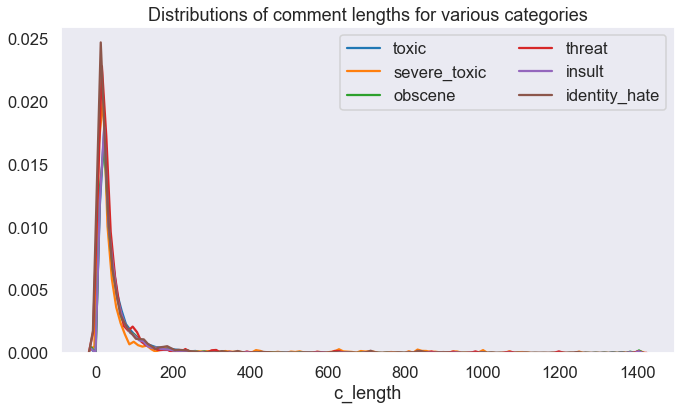

In [5]:
# Investigate Comments characteristics before our Classification 
data["c_length"] = data.txt_expanded.apply(lambda x: len(x.split(" "))) # get the comment length for each category
data['unique_words'] = data.txt_expanded.apply(lambda x: len(set(x.split(" ")))) # count unique words for each comment

'''
VISUALIZATION
1. COMMENTS LENGTH DISTRIBUTION: Plot distribution of comments length before our Classification
'''
sns.set_context("talk")
fig, axis = plt.subplots(nrows = 1, ncols = 1, figsize = (11, 6))

categories = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
for category in categories:
    sns.distplot(data[data[category] == 1].c_length, label = category, hist = False, ax = axis)

plt.legend(ncol = 2, frameon = True, fancybox = True)
plt.title("Distributions of comment lengths for various categories");

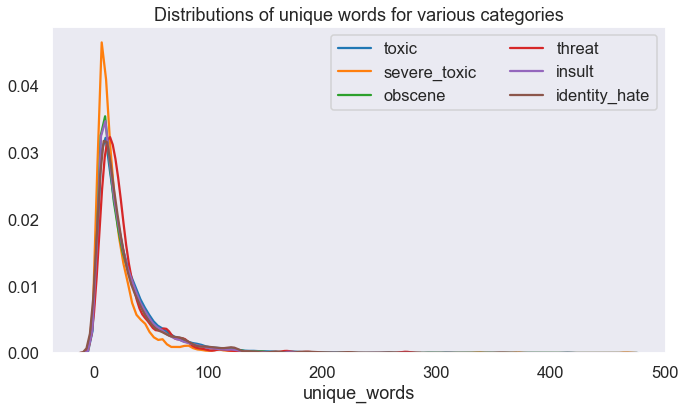

In [6]:
'''
VISUALIZATION
2. COMMENTS LENGTH DISTRIBUTION: Plot distribution of unique words before our Classification
'''
sns.set_context("talk")
fig, axis = plt.subplots(nrows = 1, ncols = 1, figsize = (11, 6))

categories = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
for category in categories:
    sns.distplot(data[data[category] == 1].unique_words, label = category, hist = False, ax = axis)

plt.legend(ncol = 2, frameon = True, fancybox = True)
plt.title("Distributions of unique words for various categories");

In [7]:
# 1. Create a CATEGORICAL LABEL in the "classe" column (6+notoxic labels) 
data["classe"] = "notoxic"
data.loc[data.toxic.isin([1]), 'classe'] = "toxic"
data.loc[data.obscene.isin([1]), 'classe'] = "obscene"
data.loc[data.insult.isin([1]), 'classe'] = "insult"
data.loc[data.severe_toxic.isin([1]), 'classe'] = "severe"
data.loc[data.identity_hate.isin([1]), 'classe'] = "hate"
data.loc[data.threat.isin([1]), 'classe'] = "threat" 
cnt = Counter(data['classe'].tolist())
assert sum([i for i in cnt.values()]) == len(data)
print(cnt)

# 2. Create a DUMMY LABEL in the "negative" column (0=Not negative, 1=Negative)
data["negative"] = 1 
data.loc[data.classe.isin(["notoxic"]), 'negative'] = 0

# Check that there isn't an overlap between negative and no negative comments
assert sum(data.negative.tolist()) + cnt['notoxic'] == len(data.negative.tolist())
print("Total number of NEGATIVE comments: {}".format(sum(data.negative.tolist())))
print("Total number of NOT NEGATIVE comments: {}".format(cnt['notoxic']))
#data.head(1)

Counter({'notoxic': 141956, 'toxic': 5631, 'insult': 5459, 'obscene': 2058, 'hate': 1296, 'severe': 1195, 'threat': 471})
Total number of NEGATIVE comments: 16110
Total number of NOT NEGATIVE comments: 141956


In [8]:
# 3. Create 7 DUMMY VARIABLES, ONE PER EACH NEW CATEGORY (based on "classe" column)
data["NOTOX"] = 0 
data["TOX"] = 0
data["INSU"] = 0
data["OBS"] = 0
data["HATE"] = 0 
data["SEV"] = 0 
data["THR"] = 0 
data.loc[data.classe.isin(['notoxic']), 'NOTOX'] = 1
data.loc[data.classe.isin(['toxic']), 'TOX'] = 1
data.loc[data.classe.isin(['insult']), 'INSU'] = 1
data.loc[data.classe.isin(['obscene']), 'OBS'] = 1
data.loc[data.classe.isin(['hate']), 'HATE'] = 1
data.loc[data.classe.isin(['severe']), 'SEV'] = 1
data.loc[data.classe.isin(['threat']), 'THR'] = 1

# Check: 
ones = [sum(data[i].tolist()) for i in ["NOTOX",'TOX','INSU','OBS','HATE','SEV','THR']]
assert sum(ones) == len(data)

In [9]:
# Move columns 
data = data[['id','classe','negative','NOTOX','TOX','INSU','OBS','HATE','SEV','THR','txt_contract','txt_expanded', 
             'tokens_ex', 'lemmas_ex','stems_ex', 'lemmas_fw_ex', 'tokens_con', 'lemmas_con', 'stems_con',
             'lemmas_fw_con','toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
data.head(1)

,id,classe,negative,NOTOX,TOX,INSU,OBS,HATE,SEV,THR,...,tokens_con,lemmas_con,stems_con,lemmas_fw_con,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,notoxic,0,1,0,0,0,0,0,0,...,explanationwhy edits username hardcore metalli...,explanationwhy edit username hardcore metallic...,explanationwhi edit usernam hardcor metallica ...,explanationwhy edit username hardcore metallic...,0,0,0,0,0,0


In [ ]:
# Save results with new dummy labels 
data.to_csv(os.path.join(b_dir,'data_LABEL3.csv'), encoding='utf-8', index=False)

### 1.3. Split the data into dedicated training, development, and test sets 
<a id="split"></a>

In [10]:
# Creating a TRAIN and DEV and TEST set 

random.seed(9) # replicability 
data = data.sample(frac=1) # randomly shuffle the dataset (index changes)

N = len(data) 
train_size = int(N*0.6) # 60% training 
dev_size = int(N*0.2) # 20% development set used to tune the parameters 
test_size = int(N*0.2) # 20% test set

train = data[:train_size]
dev = data[train_size: train_size+dev_size]
test = data[train_size+dev_size:]
classe = set(train.classe.tolist())
print("TRAIN: {}   DEV: {}   TEST: {}".format(len(train), len(dev), len(test)))

TRAIN: 94839   DEV: 31613   TEST: 31614


In [11]:
# Create 7 TRAIN sets, one per each category (cat, set in a tuple)
sub_train = [(i, train[train.classe == i]) for i in classe]
sub_train_len = [(sub_train[i][0], len(sub_train[i][1])) for i in range(len(sub_train))]
print(sub_train_len)

# Create 7 DEV sets, one per each category (cat, set in a tuple)
sub_dev = [(i, dev[dev.classe == i]) for i in classe]
sub_dev_len = [(sub_dev[i][0], len(sub_dev[i][1])) for i in range(len(sub_dev))]
print(sub_dev_len)

notox_index = [i for i in range(len(sub_dev_len)) if sub_dev_len[i][0]=="notoxic"]

[('obscene', 1186), ('insult', 3233), ('notoxic', 85244), ('hate', 777), ('threat', 286), ('severe', 732), ('toxic', 3381)]
[('obscene', 427), ('insult', 1155), ('notoxic', 28312), ('hate', 271), ('threat', 95), ('severe', 244), ('toxic', 1109)]


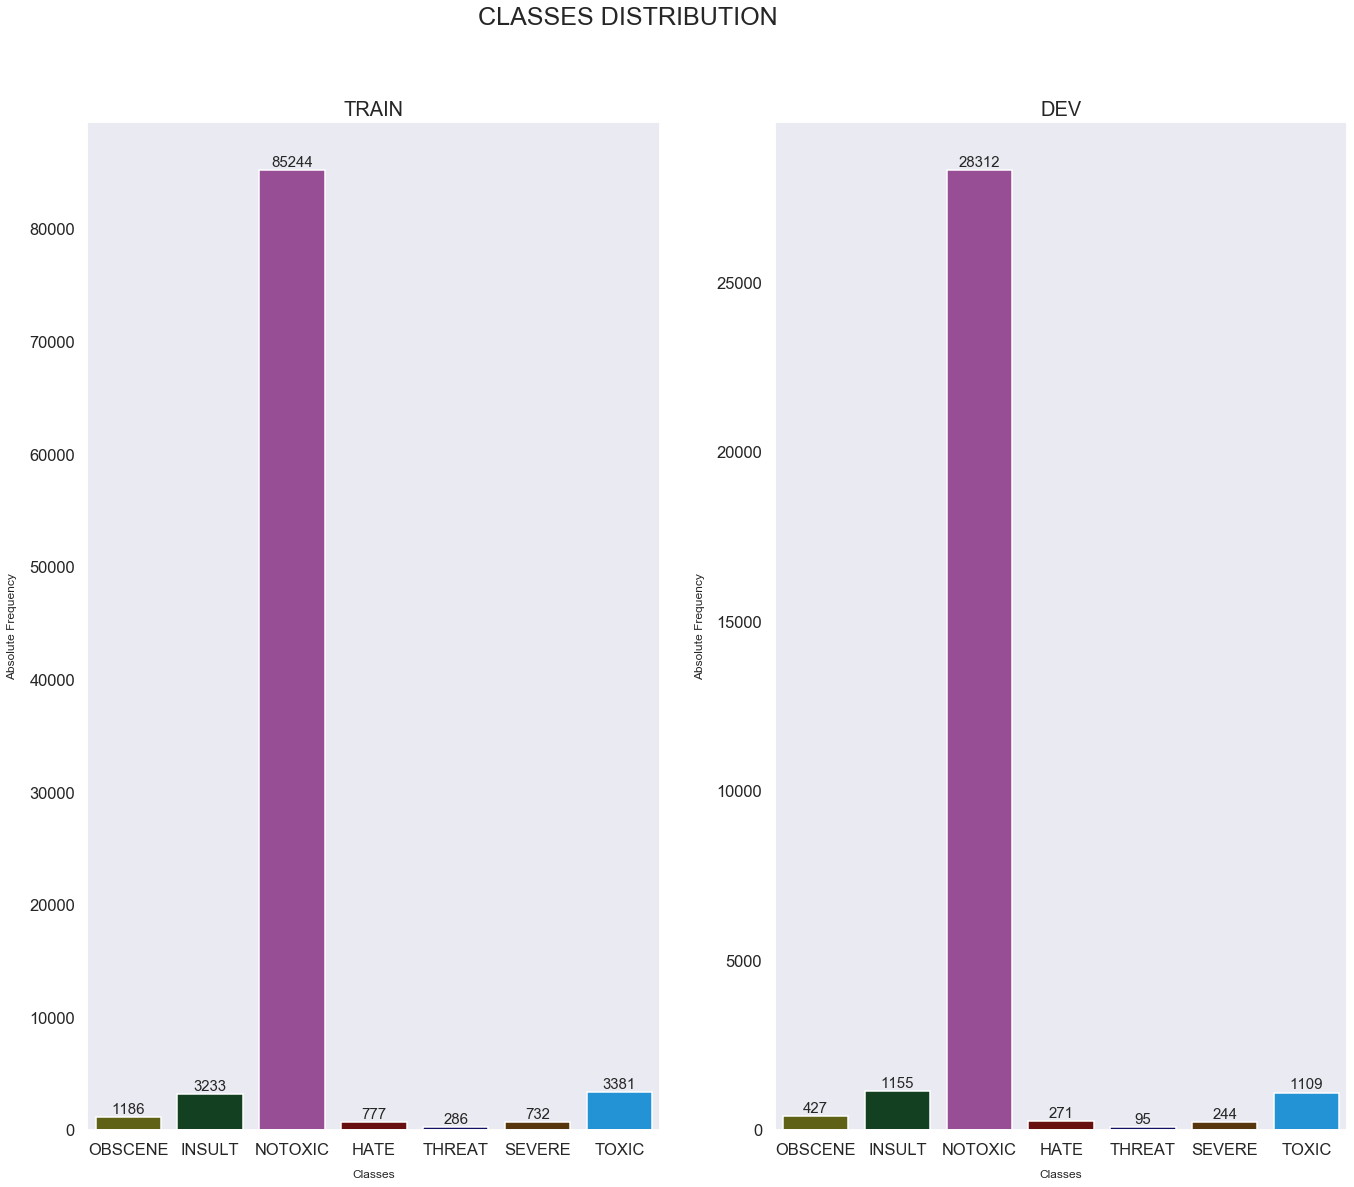

In [12]:
'''
VISUALIZATION
3. CLASSES DISTRIBUTION: Distribution of classes in the train and dev set
Finding: dataset super biased! 
'''
title = ["TRAIN", "DEV"]
subplots = [(0,0), (0,1)]
xt = [i[0].upper() for i in sub_train_len]
yt = [i[1] for i in sub_train_len]
xd = [i[0].upper() for i in sub_dev_len]
yd = [i[1] for i in sub_dev_len]
dis = [[xt,yt],[xd,yd]]

%matplotlib inline
colors_list = ["brownish green", "pine green", "ugly purple","blood", "deep blue", "brown", "azure"]
palette= sns.xkcd_palette(colors_list)
sns.set_style("dark")
plt.figure(figsize=(20,20))
plt.suptitle("CLASSES DISTRIBUTION",fontsize=25)
gridspec.GridSpec(1,2)
plt.subplots_adjust(bottom=0.2, right=1, top=0.9, hspace=0.4)

for i in range(len(dis)): 
    plt.subplot2grid((1,2),subplots[i])
    ax = sns.barplot(dis[i][0],dis[i][1], palette=palette)
    plt.title(title[i],fontsize=20)
    plt.xlabel('Classes', fontsize=12, labelpad=12)
    plt.ylabel('Absolute Frequency', fontsize=12,labelpad=12)
    rects = ax.patches
    labels = dis[i][1]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 10, label,ha='center', va='bottom', fontsize=15)
plt.show()

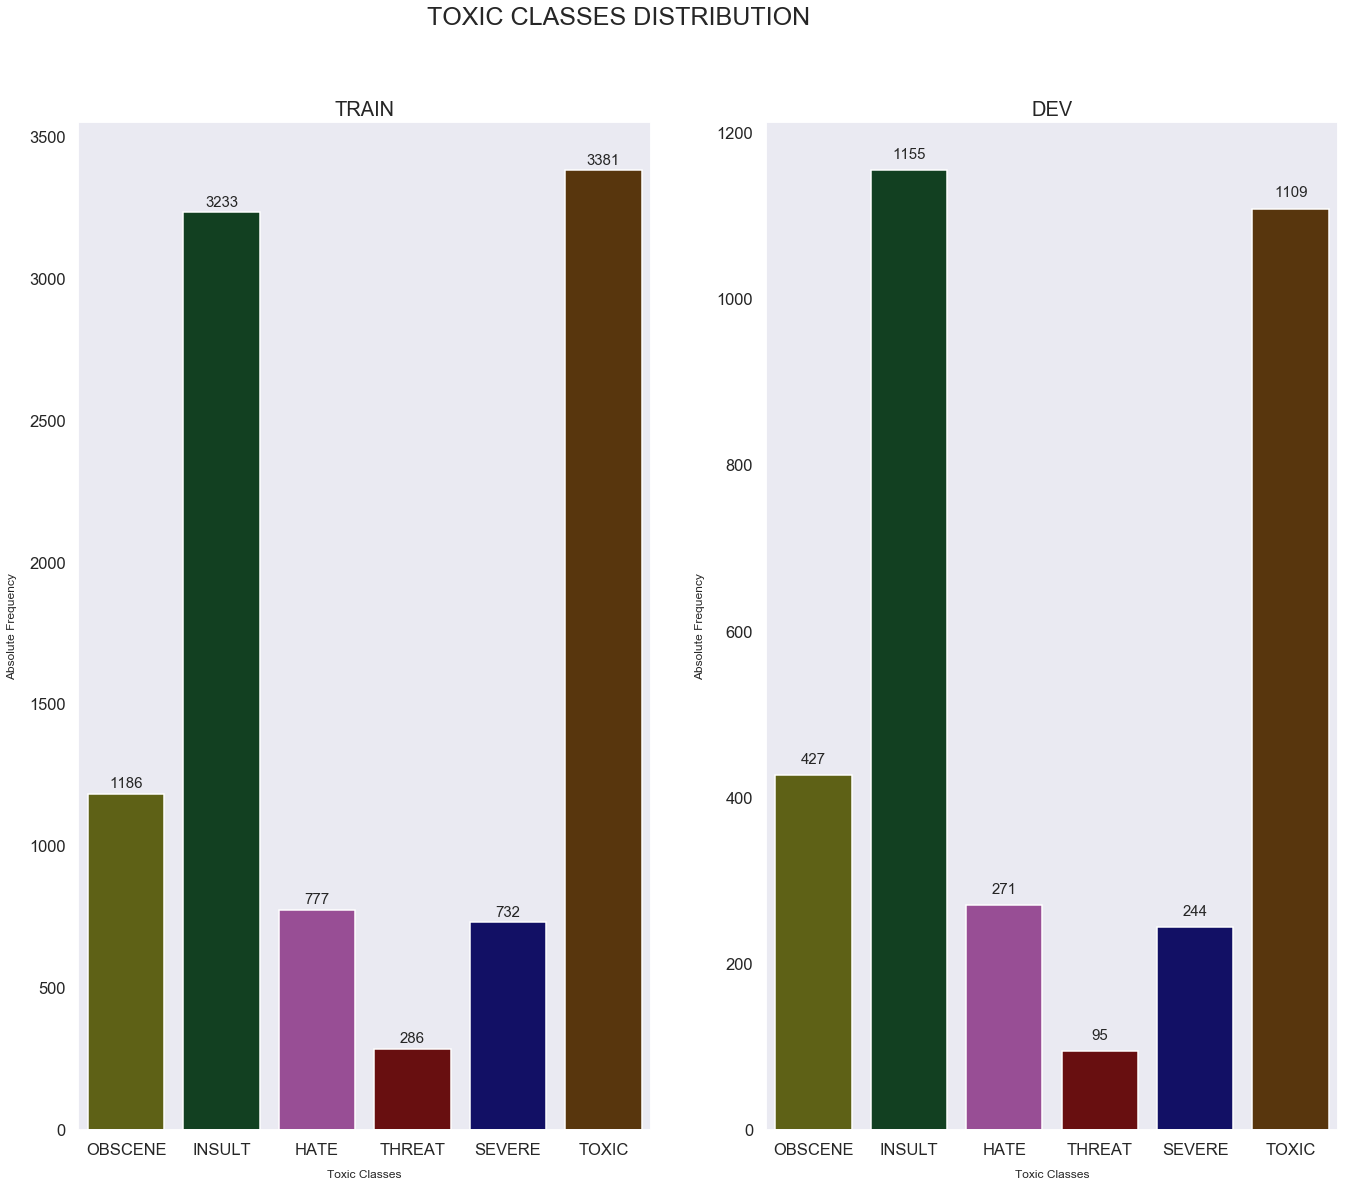

In [13]:
'''
VISUALIZATION
4. TOXIC LABELS DISTRIBUTION: Histogram of the toxic variables in the train set
Check if classes distribution is the same in the train and dev sests
'''
xt = [i[0].upper() for i in [sub_train_len[j] for j in range(len(sub_train_len)) if j!=notox_index[0]]]
yt = [i[1] for i in [sub_train_len[j] for j in range(len(sub_train_len)) if j!=notox_index[0]]]
xd = [i[0].upper() for i in [sub_dev_len[j] for j in range(len(sub_dev_len)) if j!=notox_index[0]]]
yd = [i[1] for i in [sub_dev_len[j] for j in range(len(sub_dev_len)) if j!=notox_index[0]]]

title = ["TRAIN", "DEV"]
subplots = [(0,0), (0,1)]
dis = [[xt,yt],[xd,yd]]

%matplotlib inline
colors_list = ["brownish green", "pine green", "ugly purple","blood", "deep blue", "brown", "azure"]
palette= sns.xkcd_palette(colors_list)
sns.set_style("dark")
plt.figure(figsize=(20,20))
plt.suptitle("TOXIC CLASSES DISTRIBUTION",fontsize=25)
gridspec.GridSpec(1,2)
plt.subplots_adjust(bottom=0.2, right=1, top=0.9, hspace=0.4)

for i in range(len(dis)): 
    plt.subplot2grid((1,2),subplots[i])
    ax = sns.barplot(dis[i][0],dis[i][1], palette=palette)
    plt.title(title[i],fontsize=20)
    plt.xlabel('Toxic Classes', fontsize=12, labelpad=12)
    plt.ylabel('Absolute Frequency', fontsize=12,labelpad=12)
    rects = ax.patches
    labels = dis[i][1]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 10, label,ha='center', va='bottom', fontsize=15)
plt.show()

20 26


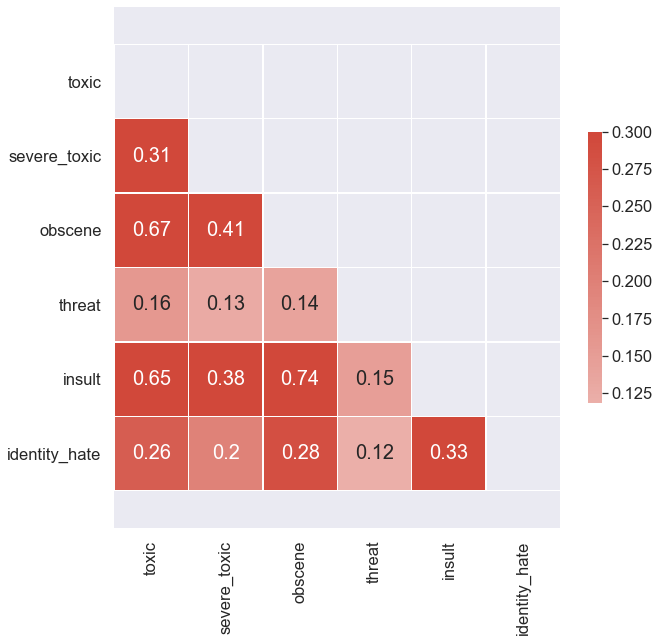

In [14]:
'''
VISUALIZATION
5. LABELS CORRELATION: Correlation scores for comment type occurrences in the train set 
Correlation on the diagonals are = 1
Correlation matrix is symmetric therefore we can just visualize it off-diagonal
'''
up = train.columns.get_loc("identity_hate")+1
low = train.columns.get_loc("toxic")
print(low, up)
temp_df=train.iloc[:,low:up]
corr=temp_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool)) #diagonal mask 
f, ax = plt.subplots(figsize=(10, 10))

sns.set(font_scale=1.5)
cmap = sns.diverging_palette(250,15,as_cmap=True)
sns.heatmap(corr, mask=mask,cmap=cmap , vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5},
            xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, annot_kws={"size": 20})

b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show() 

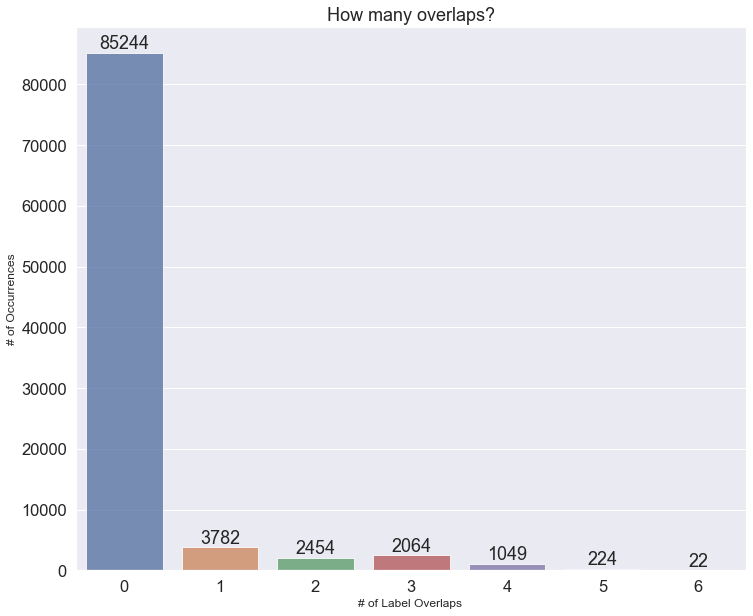

In [15]:
'''
VISUALIZATION
6. LABELS CORRELATION: How many observations have more than 1 labels? More than 2? Only one?  
'''
rowsums = train.iloc[:,low:up].sum(axis=1)
x = rowsums.value_counts()

#plot
plt.figure(figsize=(12,10))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("How many overlaps?")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Label Overlaps ', fontsize=12)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## 2. Research Question(s) (2 pts)
<a id="res"></a>
### Describe what question you are investigating with the data. (100 w)
1. **How to detect toxic comments?**   
*Given our dataset, we would like to understand if there's a possibility to predict how toxic a comment is, looking at the words and topics in it.*  
There’s an interesting trend in online communities at the moment: Many people use social media and other online channels to express aggressive and negative comments, helped also by the fact that it's harder to identify people online. Therefore, this application can be useful to help all the owners of online platforms to avoid these toxoc behaviors.

2. **How to find rhymes in a poem?**   
*Given a dataset of English Poems, we would like to find a fast way to detect rhymes, even if poems contain different rhyme structures.*  
There are many different types of rhymes that poets use in their work: Internal rhymes, slant rhymes, eye rhymes, identical rhymes, and more. This application of a structured prediction task can be a starting point for people who want to write in rymes to check their sentences. It can also be used by nursery rhyme publishers to check books before publishing them.

## 3. Analysis (6 pts)
<a id="anal"></a>
Apply at least one version of *each* of the following analysis methods to the data set **(justify your choices)**.  
Your analysis needs to be run on the training data only! **You can use the dev set for tuning.**

### 3.1. Topic modeling with LDA (3 pts) 
<a id="lda"></a>

**Number of topics:**  6   
**Justification:**    
Given that comments are all about Wikipedia edits, this number shouldn't be very high and should be smaller than 7, the number of toxicity shades. From our tuning we got 6 as number of topics and we set alpha to 0.1

In [97]:
def topics(df_train,df_dev, column:str, alfa=0.5,start=3, end=7,num_topics=False,no_below=10,no_above=0.1):
    '''
    Aim: Choose the best num_topics according to the computed measures and return the topics 
    Parameters: 
    1) df = dataframe
    2) column = df column from which get the corpus [lemmas or tokens? 
        (6 options: tokens_ex, tokens_con, lemmas_ex, lemmas_con, lemmas_fw_ex, lemmas_fw_con)]
    3) alfa = LDA alpha (how much common are topics to all documents?)
    4) start = min number of topics
    5) end = max number of topics
    '''
    
    dc = df_train.copy()
    instances = dc[column].apply(str).apply(str.split)
    docs_CLUST = [" ".join(i) for i in instances]
    dct = Dictionary(instances) # defining dictionary 
    dct.filter_extremes(no_below=no_below, no_above=no_above) 
    #print(dct, flush=True)
    LDA_corpus = [dct.doc2bow(text) for text in instances]
    TFIDFmodel = TfidfModel(LDA_corpus)
    model_corpus = TFIDFmodel[LDA_corpus]
    
    dc_dev = df_dev.copy()
    instances_dev = dc_dev[column].apply(str).apply(str.split)

    n_top_df=None
    def number_topics(model_corpus, instances_dev, dct, start, end):
        
        '''
        Aim: Choose the best number of topics based on cv and u_mass scores 
        '''
        coherence_values = []


        for num_topics1 in range(start,end):
            model = LdaMulticore(corpus=model_corpus, id2word=dct, num_topics=num_topics1)

            coherencemodel_umass = CoherenceModel(model=model,texts=instances_dev,
                                                  dictionary=dct,coherence='u_mass')

            coherencemodel_cv = CoherenceModel(model=model,texts=instances_dev,
                                               dictionary=dct,coherence='c_v')

            umass_score = coherencemodel_umass.get_coherence()
            cv_score = coherencemodel_cv.get_coherence()

            print(num_topics1, umass_score, cv_score)
            coherence_values.append((num_topics1, umass_score, cv_score))

        ## PLOT: Coherence Measures
        %matplotlib inline
        sns.set_context('poster') 
        scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(start,end))
        scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(start,end))
        plt.show()

        n_top_df=pd.DataFrame(coherence_values, columns=["num_topics","umass_score","cv_score"])
        n_top_df["score"]=n_top_df["umass_score"]+n_top_df["cv_score"]
        n_top_df=n_top_df.sort_values(by="score",ascending=False)
        x=int(n_top_df["num_topics"][0])

        assert type(x)==int and x <= end and x>= start
        return x,n_top_df
    x,n_top_df= number_topics(model_corpus, instances_dev, dct, start, end)
    return x,n_top_df


3 -2.307483042622477 0.4538462466478772
4 -2.1937728800937797 0.4491526379997347
5 -2.2024353285114953 0.47150963900106957
6 -2.2206227761888013 0.4611072589992518


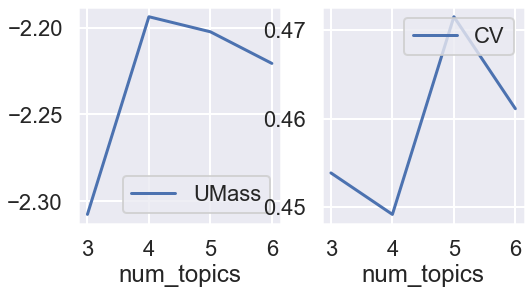

3 -2.2642779885076316 0.44956775390948495
4 -2.2647778884993714 0.4547358623610547
5 -2.236760843792099 0.4721744255864061
6 -2.3145562481533024 0.4740466422936183


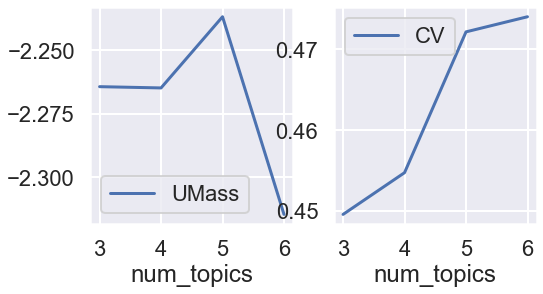

3 -2.1952134793882623 0.4550181223456707
4 -2.2322460991744806 0.47188894908300577
5 -2.2653140543983588 0.49091058124300346
6 -2.3812397762201014 0.4783351574405659


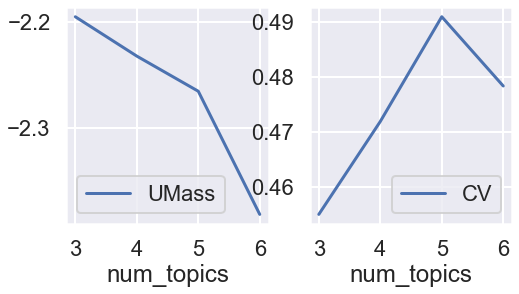

3 -2.29358065499555 0.4374341076849726
4 -2.295030358015996 0.4511088066514669
5 -2.3139523826826967 0.46892289482160177
6 -2.405636890167006 0.46090099113671007


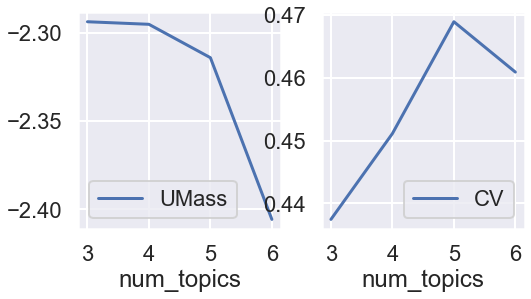

3 -2.3230216586452905 0.4497492812496111
4 -2.346870403268503 0.48039822890827355
5 -2.2536815913858415 0.4543226260573429
6 -2.1996990284213864 0.4880633417957283


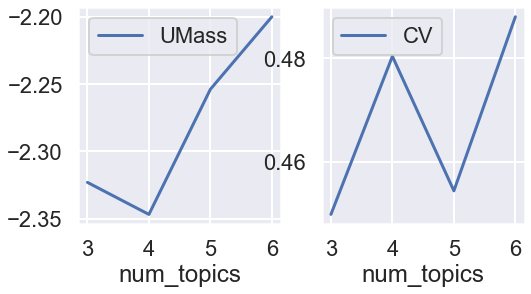

3 -2.240008842830014 0.49889273422214964
4 -2.2066731838131814 0.5071108827928169
5 -2.154536781544354 0.4904750344335504
6 -2.1557740991335463 0.5148856818614651


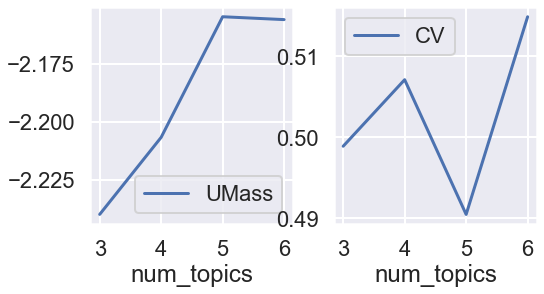

3 -2.2948423348304963 0.48543815413857133
4 -2.1915651923495965 0.4810033632345889
5 -2.166038264359694 0.5131894382515639
6 -2.325810488603796 0.49306915236492976


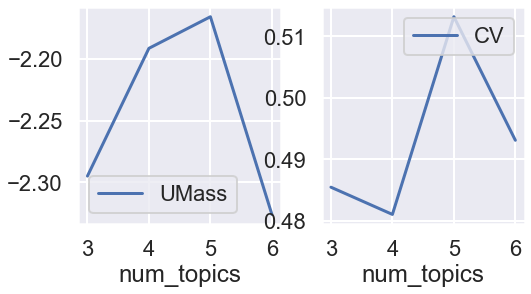

3 -2.164127173165299 0.5054554011927849
4 -2.2247978066680387 0.4909625560272093
5 -2.180143128880845 0.5267755951741029
6 -2.1573025529423275 0.5076539038914302


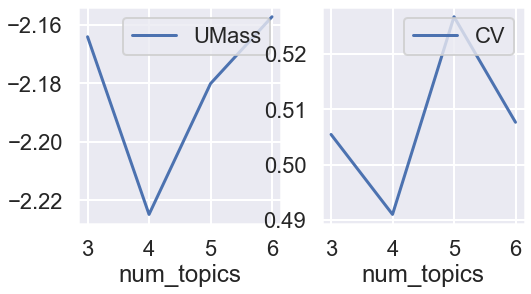

3 -2.272292818850698 0.47994945677595285
4 -2.2076947962378126 0.4977842615197089
5 -2.195245027889944 0.4856199467410594
6 -2.257050636536095 0.49671085642511664


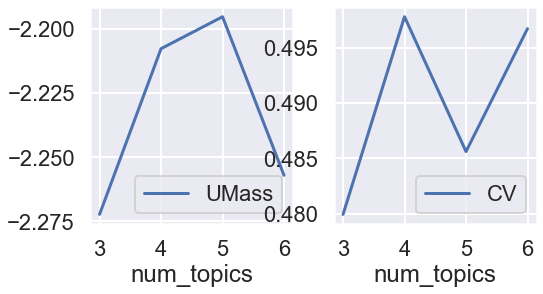

3 -2.168751940257263 0.4965198473702152
4 -2.2164762258009687 0.5103928346081531
5 -2.3689986646085766 0.46943760995709105
6 -2.2065915093755786 0.49849137849992126


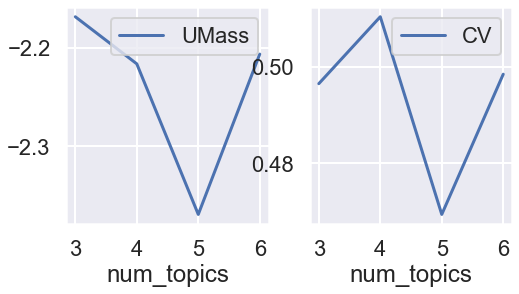

,num_topics,umass_score,cv_score,score,alpha,no_below,no_above
3,6,-2.155774,0.514886,-1.640888,0.1,10,0.15
3,6,-2.157303,0.507654,-1.649649,0.3,10,0.15
2,5,-2.166038,0.513189,-1.652849,0.2,10,0.15
0,3,-2.168752,0.496520,-1.672232,0.5,10,0.15
2,5,-2.195245,0.485620,-1.709625,0.4,10,0.15
3,6,-2.199699,0.488063,-1.711636,0.5,10,0.10
2,5,-2.202435,0.471510,-1.730926,0.1,10,0.10
0,3,-2.195213,0.455018,-1.740195,0.3,10,0.10
2,5,-2.236761,0.472174,-1.764586,0.2,10,0.10
1,4,-2.295030,0.451109,-1.843922,0.4,10,0.10


In [104]:
# TUNING OF ALPHA PARAMETER
alphas = [0.1,0.2,0.3,0.4,0.5]
no_belows=[10]
no_aboves=[0.1,0.15]
np.random.seed(9)
results = []
best_model=pd.DataFrame()
count=0
for no_below in no_belows: 
    for no_above in no_aboves: 
        for i in alphas: 
            x,df_score = topics(train,dev, 'lemmas_fw_ex', alfa=i,no_below=no_below,no_above=no_above)
            df_score=df_score.iloc[:1]
            df_score["alpha"]=i
            df_score["no_below"]=no_below
            df_score["no_above"]=no_above
            if count==0:
                best_model=df_score
            else:
                best_model=pd.concat([best_model,df_score],axis=0)
            count+=1
best_model=best_model.sort_values(by="score",ascending=False)
best_model

In [105]:
def topics2(df, column:str, alfa=0.5,num_topics=5,no_below=10,no_above=0.1):
    '''
    Aim: Choose the best num_topics according to the computed measures and return the topics 
    Parameters: 
    1) df = dataframe
    2) column = df column from which get the corpus [lemmas or tokens? 
        (6 options: tokens_ex, tokens_con, lemmas_ex, lemmas_con, lemmas_fw_ex, lemmas_fw_con)]
    3) alfa = LDA alpha (how much common are topics to all documents?)
    4) start = min number of topics
    5) end = max number of topics
    '''
    
    dc = df.copy()
    instances = dc[column].apply(str).apply(str.split)
    docs_CLUST = [" ".join(i) for i in instances]
    dct = Dictionary(instances) # defining dictionary 
    dct.filter_extremes(no_below=no_below, no_above=no_above) 
    #print(dct, flush=True)
    LDA_corpus = [dct.doc2bow(text) for text in instances]
    TFIDFmodel = TfidfModel(LDA_corpus)
    model_corpus = TFIDFmodel[LDA_corpus]   
    num_passes = 10
    chunk_size = len(model_corpus) * num_passes/200
    #print(chunk_size)

    start = time.time()
    print("Fitting model...", flush=True)
    model = LdaMulticore(num_topics=num_topics,corpus=model_corpus,id2word=dct,
                         workers=min(10, multiprocessing.cpu_count()-1),passes=num_passes, chunksize=chunk_size, 
                         alpha=alfa) #0.5
    print("Done in {}".format(time.time()-start), flush=True)

    ## Transform data into topic distributions 
    topic_corpus = model[model_corpus]
    topic_sep = re.compile(r"0\.[0-9]{3}\*") 
    model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                    model.print_topics(num_topics=num_topics, num_words=5)]

    descriptors = []
    for i, m in model_topics:
        print(i+1, ", ".join(m[:5]))
        descriptors.append(", ".join(m[:5]).replace('"', ''))
    
    print()
    return topic_corpus, descriptors, docs_CLUST

In [106]:
best_alpha=float(best_model["alpha"].iloc[0])
best_no_below=int(best_model["no_below"].iloc[0])
best_no_above=float(best_model["no_above"].iloc[0])
best_topics=int(best_model["num_topics"].iloc[0])
np.random.seed(9)
topic_corpus, descriptors, docs_CLUST=topics2(train,'lemmas_fw_ex', alfa=best_alpha,no_below=best_no_below,no_above=best_no_above,num_topics=best_topics)

Fitting model...
Done in 143.31158089637756
1 "like", "think", "know", "source", "people"
2 "edit", "block", "user", "revert", "thank"
3 "thank", "help", "welcome", "edit", "question"
4 "source", "think", "know", "reference", "people"
5 "deletion", "fuck", "delete", "redirect", "speedy"
6 "image", "thank", "copyright", "edit", "vandalize"



#### 3.1.1. LDA + DEPENDENT VARIABLE
**Justification:** How do topics change according to the 7 toxicity categories? 
<a id="lda2"></a>

In [107]:
# LDA + Dependent Variable 
target_category = 'classe'

# get a list of all the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(train))]
print(scores[0])

topic_distros = pd.DataFrame(data=scores, columns=descriptors)
topic_distros['category'] = train[target_category].tolist() 
#topic_distros.head()

[0.02515314, 0.02515649, 0.02515592, 0.87421906, 0.02515732, 0.02515805]


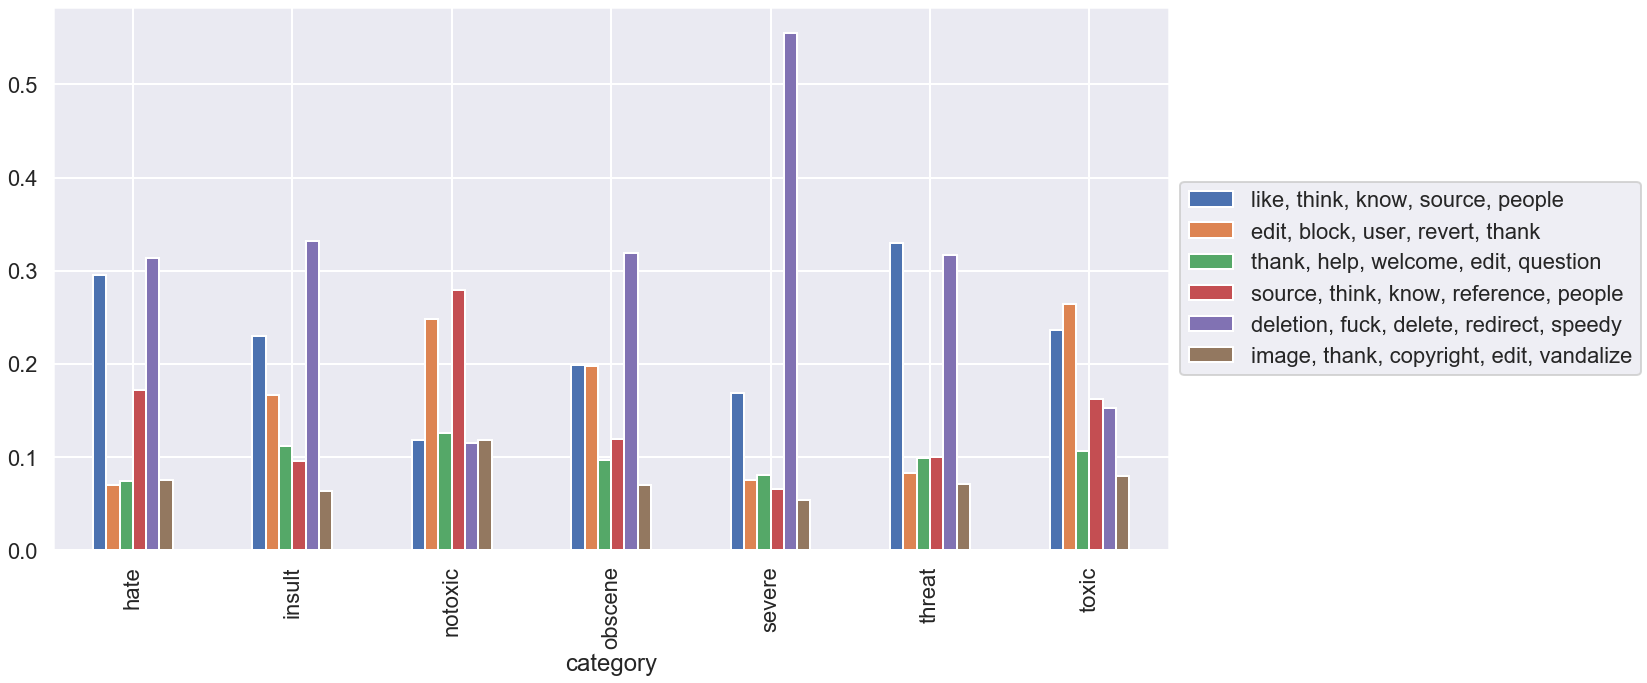

In [108]:
'''
VISUALIZATION 
7. TOPICS DISTRIBUTION: What are different toxic comments about, given their class?
'''
sns.set_context('poster') 
fig, ax = plt.subplots(figsize=(20, 10)) 

aggregate_by_category = topic_distros[topic_distros.category.isin(classe)]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
aggregate_by_category[descriptors].plot.bar(ax=ax);
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

#### 3.1.2 LDA with only negative comments
<a id="lda3"></a>
Now we look at topics across negative comments. From the tuning, it turned out that the best number of parameter is 3 while alpha=0.3.

3 -2.9945478253583464 0.39868368337776
4 -2.691223076654688 0.42796660590999147
5 -3.072388924604293 0.4361357951139177
6 -2.8289894389185446 0.4533633961565293


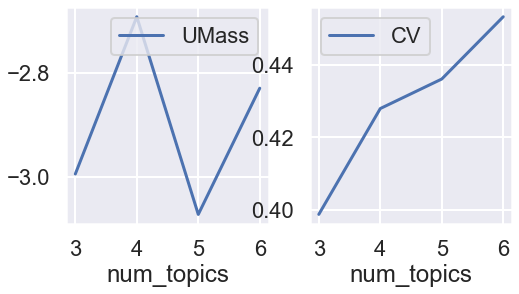

3 -2.787775712225827 0.39323710299483644
4 -2.714093032045884 0.4411469638335497
5 -2.9932662554621254 0.4741814247533654
6 -2.9966839288682987 0.4360482340821867


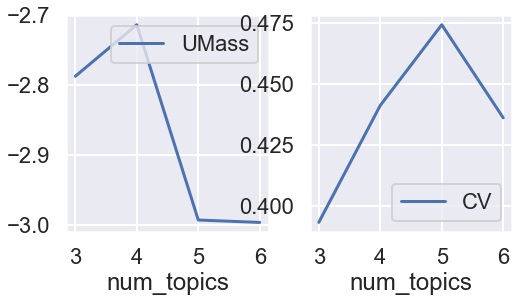

3 -2.7151288607461193 0.40683005052259347
4 -3.036308709886197 0.44179459258589027
5 -3.0449350578478755 0.4368448100234577
6 -3.0282058409588672 0.39852209262390653


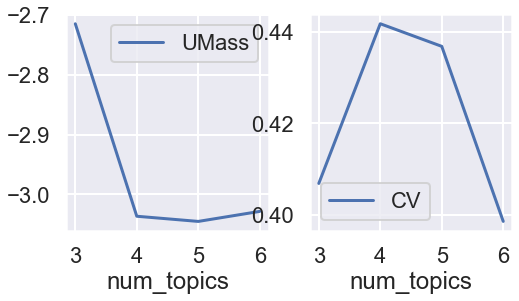

3 -2.618482853425379 0.3892318465815892
4 -2.753687601973655 0.421701903344077
5 -3.0289291729641965 0.4204017881912677
6 -2.673290220725017 0.4600434360723089


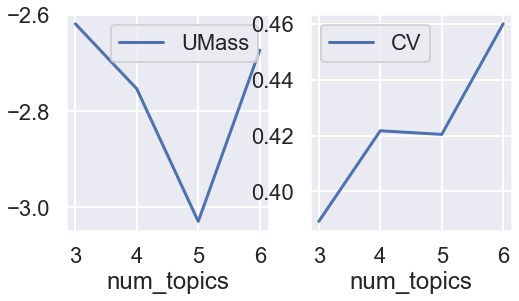

3 -2.9657548122139232 0.3854436099805405
4 -2.6315873665512868 0.43331312527829524
5 -3.039517052263184 0.4252775554553936
6 -2.8379130134429 0.4374724978235585


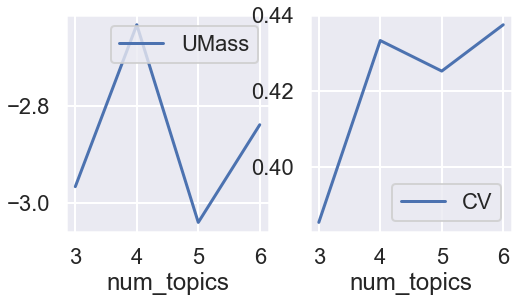

3 -2.5361917132878844 0.4578335965667957
4 -2.838087957574627 0.4994513939456838
5 -2.694262044700418 0.43721320965780175
6 -2.730381777141902 0.45059009106682985


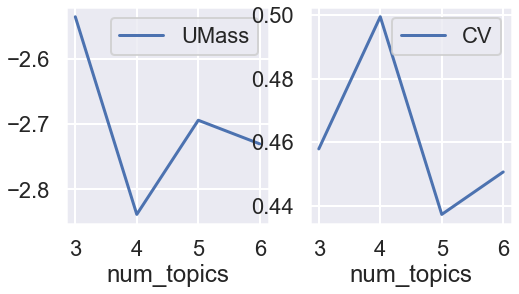

3 -2.462505595019121 0.4983965877985073
4 -3.023907058710867 0.44220404079478676
5 -2.9105401324668825 0.4385297227165831
6 -2.7712606054615265 0.4381090364566733


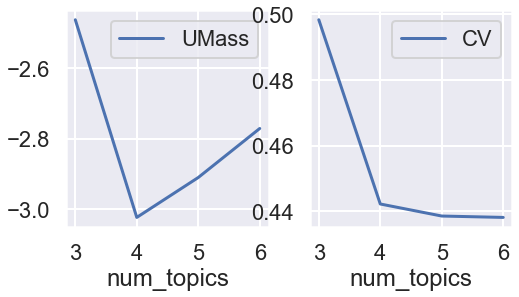

3 -2.331498022519406 0.49478042753089735
4 -2.6160410936308436 0.47141736158055997
5 -2.663843507184174 0.47912588209250195
6 -2.7952252568657534 0.49732168558505796


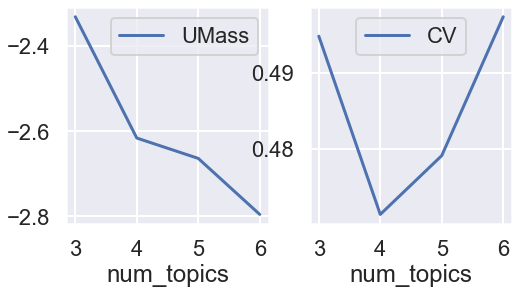

3 -2.7292598539082356 0.45230637312799477
4 -2.7299430766133574 0.44811570504314263
5 -2.629089465977809 0.4908292291631124
6 -2.879889099524194 0.4802020261740121


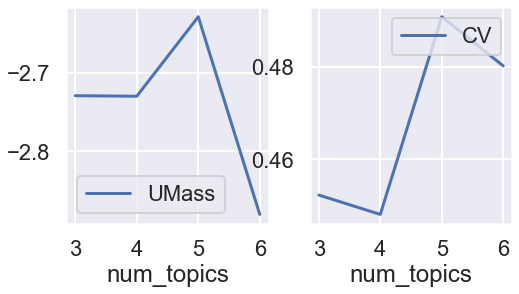

3 -2.59687651723984 0.4381620625188365
4 -2.86674729877016 0.4426843992938848
5 -2.8958893517726687 0.46681610557191117
6 -2.56392429797629 0.4946635622195499


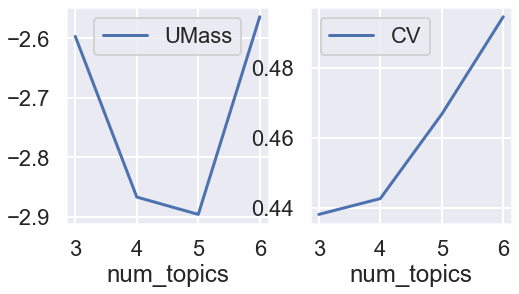

,num_topics,umass_score,cv_score,score,alpha,no_below,no_above
0,3,-2.331498,0.494780,-1.836718,0.3,10,0.15
0,3,-2.462506,0.498397,-1.964109,0.2,10,0.15
3,6,-2.563924,0.494664,-2.069261,0.5,10,0.15
0,3,-2.536192,0.457834,-2.078358,0.1,10,0.15
2,5,-2.629089,0.490829,-2.138260,0.4,10,0.15
1,4,-2.631587,0.433313,-2.198274,0.5,10,0.10
3,6,-2.673290,0.460043,-2.213247,0.4,10,0.10
1,4,-2.691223,0.427967,-2.263256,0.1,10,0.10
1,4,-2.714093,0.441147,-2.272946,0.2,10,0.10
0,3,-2.715129,0.406830,-2.308299,0.3,10,0.10


In [109]:
# TUNING OF ALPHA PARAMETER
alphas = [0.1,0.2,0.3,0.4,0.5]
no_belows=[10]
no_aboves=[0.1,0.15]
np.random.seed(9)
results = []
best_model=pd.DataFrame()
count=0
for no_below in no_belows: 
    for no_above in no_aboves: 
        for i in alphas: 
            x,df_score = topics(train[train["negative"]==1],dev[dev["negative"]==1], 'lemmas_fw_ex', alfa=i,no_below=no_below,no_above=no_above)
            df_score=df_score.iloc[:1]
            df_score["alpha"]=i
            df_score["no_below"]=no_below
            df_score["no_above"]=no_above
            if count==0:
                best_model=df_score
            else:
                best_model=pd.concat([best_model,df_score],axis=0)
            count+=1
best_model=best_model.sort_values(by="score",ascending=False)
best_model

In [110]:
best_alpha=float(best_model["alpha"].iloc[0])
best_no_below=int(best_model["no_below"].iloc[0])
best_no_above=float(best_model["no_above"].iloc[0])
best_topics=int(best_model["num_topics"].iloc[0])
np.random.seed(9)
topic_corpus, descriptors, docs_CLUST=topics2(train[train["negative"]==1],'lemmas_fw_ex', alfa=best_alpha,no_below=best_no_below,no_above=best_no_above,num_topics=best_topics)

Fitting model...
Done in 12.104074954986572
1 "bitch", "suck", "shit", "fucking", "dick"
2 "wikipedia", "page", "edit", "article", "talk"
3 "gay", "know", "faggot", "racist", "penis"



In [113]:
# LDA + Dependent Variable 
target_category = 'classe'

# get a list of all the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(train[train["negative"]==1]))]
print(scores[0])

topic_distros = pd.DataFrame(data=scores, columns=descriptors)
topic_distros['category'] = train[train["negative"]==1][target_category].tolist() 
#topic_distros.head()

[0.14477406, 0.12008406, 0.7351419]


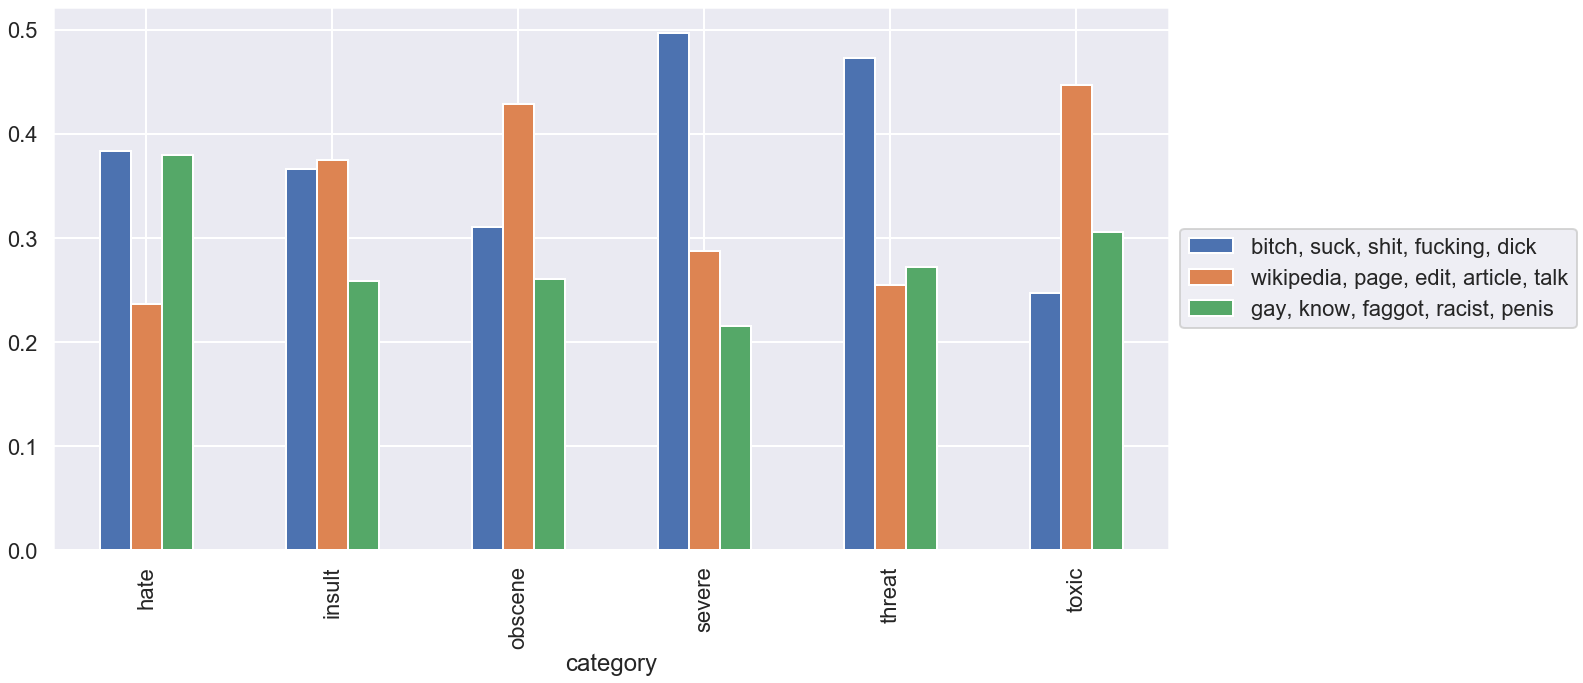

In [114]:
'''
VISUALIZATION 
8. TOPICS DISTRIBUTION: What are negtive comments about, given their class?
'''
sns.set_context('poster') 
fig, ax = plt.subplots(figsize=(20, 10)) 

aggregate_by_category = topic_distros[topic_distros.category.isin(classe)]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
aggregate_by_category[descriptors].plot.bar(ax=ax);
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### 3.2. Dense word embeddings or document embeddings: visualize these and show a clustering (3 pts)
<a id="doc"></a>
#### 3.2.1. Docs Embeddings 
<a id="doc1"></a>
**Justification:**  
Are threat comments more aggressive than hate ones? Are obscene similar to insult comments?   
Understanding how our 7 toxic labels are related between each other. We used the dev sample to tune the best parameters for our final model, it turned out that the most appropriate number of dimensions is 100, while the best min_count is 20.

In [115]:
# TUNING
np.random.seed(9)
corpus_dev = []
for row in dev.iterrows():  
    text = row[1].tokens_ex
    label = row[1].classe
    corpus_dev.append(TaggedDocument(text.split(), tags=[str(label)])) 
vect_size=[50,100,150,200,250,300]
min_val_count=[20,100]
size_sim_df=pd.DataFrame()
count=0
for min_count in min_val_count:
    for size in vect_size:
        d2v_model = Doc2Vec(vector_size=size,window=15, hs=0,sample=0.00001,negative=5,min_count=min_count,
                        workers=-1,epochs=500,dm=1,dbow_words=0)
        d2v_model.build_vocab(corpus_dev)
        d2v_model.train(corpus_dev, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
        d = d2v_model.docvecs.doctags
        classes = list(d.keys())
        la = []
        w=[]
        
        for i in classes: 
            a = d2v_model.docvecs.most_similar(i, topn=2)[0][0]
            la.append(a)
            w.append(d2v_model.wv.most_similar([d2v_model.docvecs[i]], topn=1)[0][0])
        c=[min_count for i in range(len(la))]
        doc2vec = pd.DataFrame(data={"vector_size":[size for i in range(len(la))],"min_count":c,'category':classes, "Most similar class":la,"Most similar word":w})
        if count==0:
            size_sim_df=doc2vec
        else:
            size_sim_df=pd.concat([size_sim_df,doc2vec],axis=0)
        count+=1
size_sim_df

,vector_size,min_count,category,Most similar class,Most similar word
0,50,20,notoxic,insult,errors
1,50,20,hate,severe,babies
2,50,20,severe,hate,verbatim
3,50,20,toxic,hate,solid
4,50,20,insult,notoxic,large
...,...,...,...,...,...
2,300,100,severe,hate,willing
3,300,100,toxic,notoxic,sexual
4,300,100,insult,hate,women
5,300,100,obscene,notoxic,logged


In [129]:
# Final Doc2Vec
np.random.seed(9)
corpus = []
for row in train.iterrows():  
    text = row[1].tokens_ex
    label = row[1].classe
    corpus.append(TaggedDocument(text.split(), tags=[str(label)])) 

best_vector_size=100
best_min_count=20
d2v_model = Doc2Vec(vector_size=best_vector_size,window=15, hs=0,sample=0.00001,negative=5,min_count=best_min_count,
                    workers=-1,epochs=500,dm=1,dbow_words=0)

In [130]:
np.random.seed(9)
d2v_model.build_vocab(corpus)
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
d = d2v_model.docvecs.doctags
classes = list(d.keys())

In [131]:
# Which are the most similar label categories, looking at comments' content? 
la = []
lb = []
for i in classes: 
    a = d2v_model.docvecs.most_similar(i, topn=2)[0][0]
    b = d2v_model.docvecs.most_similar(i, topn=2)[1][0]
    la.append(a)
    lb.append(b)
doc2vec = pd.DataFrame(data={'category':classes, "I similarity":la, "II similarity":lb})
doc2vec

,category,I similarity,II similarity
0,notoxic,obscene,insult
1,toxic,hate,insult
2,insult,notoxic,toxic
3,hate,severe,toxic
4,obscene,notoxic,severe
5,severe,hate,obscene
6,threat,severe,hate


In [132]:
# Which are the top 10 strongest words associated with a label category?
d2v_model.wv.most_similar([d2v_model.docvecs['obscene']], topn=5)

[('vast', 0.3925406336784363),
 ('directory', 0.3668370842933655),
 ('crusaders', 0.33690643310546875),
 ('phone', 0.3364037871360779),
 ('phrasing', 0.3346397876739502)]

In [133]:
# Most similar word per category:
words1 = []
for i in classes:
    a = d2v_model.wv.most_similar([d2v_model.docvecs[i]])
    print("The word most similar to {} label is {}.".format(i.upper(),a[0][0]))
    words1.append((a[0][0],i))

The word most similar to NOTOXIC label is population.
The word most similar to TOXIC label is kent.
The word most similar to INSULT label is women.
The word most similar to HATE label is milan.
The word most similar to OBSCENE label is vast.
The word most similar to SEVERE label is seriously.
The word most similar to THREAT label is esperanza.


In [134]:
# Which are the words most similar to a given type? (possiamo fare anche D2V al posto di W2V)
#d2v_model.wv.vocab
d2v_model.wv.most_similar("hate") 

[('gained', 0.3496692478656769),
 ('america', 0.3427824378013611),
 ('stars', 0.3394584655761719),
 ('admi', 0.3382999002933502),
 ('landed', 0.335384726524353),
 ('indicate', 0.3327495753765106),
 ('italicized', 0.3326764702796936),
 ('obtain', 0.3297280967235565),
 ('backlash', 0.3248957395553589),
 ('circumstance', 0.3236992359161377)]

In [135]:
'''
VISUALIZATION
9. IMPORTANT TERMS: Scatterplot of words similarity (Doc2Vec)
'''
%matplotlib inline

def closestwords_Doc2Vec(word):
    model = d2v_model
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]
    close_words = model.wv.most_similar(word)
    
    # Add the vector of each closest word to an array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # Reduce vectors dimensions from 100 to 2 with t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # Scatterplot
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(x_coords, y_coords, alpha=0.3, s=200)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        if label == word:
            ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',horizontalalignment="left",
                        verticalalignment="top",fontsize=20, color="red")
        else:
            ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',horizontalalignment="left",
                        verticalalignment="top",fontsize=20)
            
    ax.set_xlim(x_coords.min()-300, x_coords.max()+300)
    ax.set_ylim(y_coords.min()-300, y_coords.max()+300)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title("Doc2Vec: Words similarity", fontsize=25)
    plt.show()

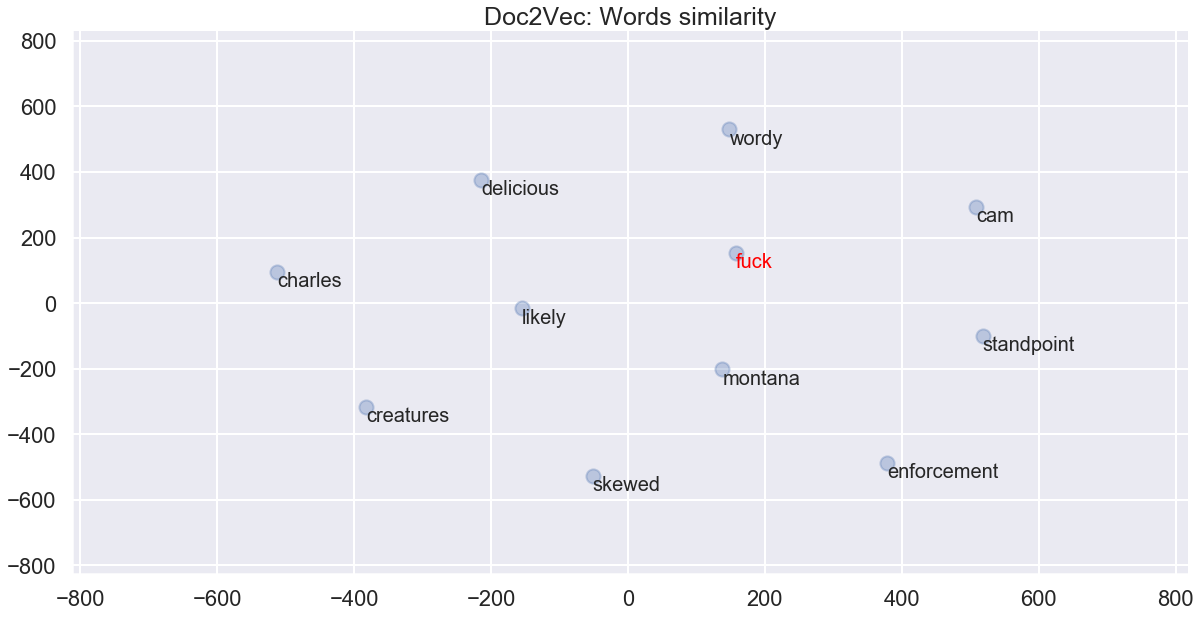

In [136]:
closestwords_Doc2Vec("fuck")

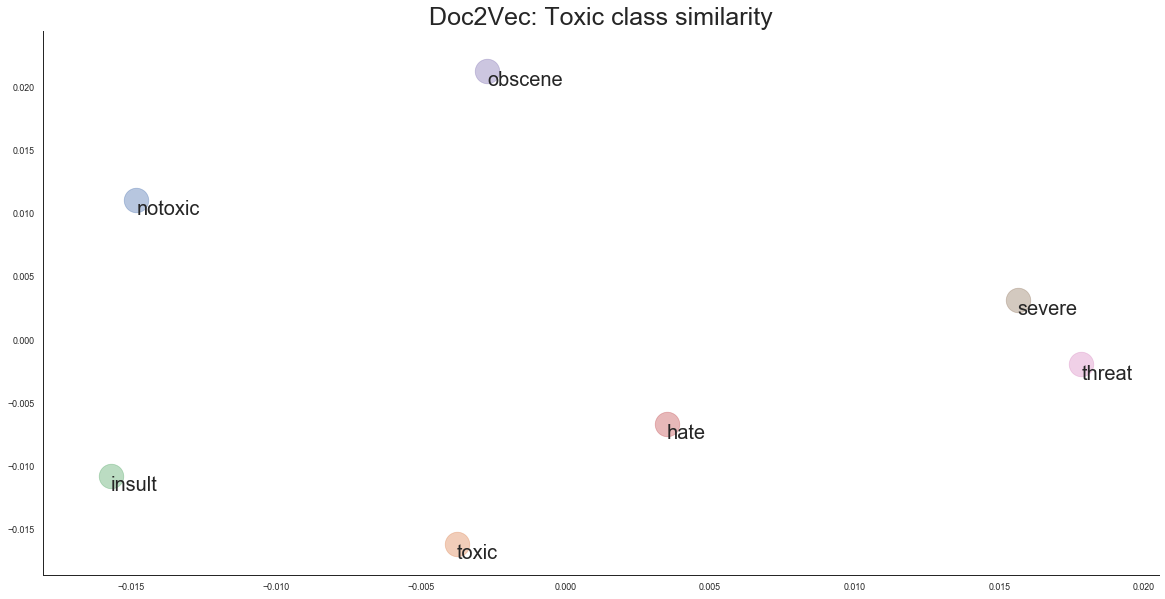

In [189]:
'''
VISUALIZATION
10. CATEGORY SIMILARITY: Scatterplot of Category similarity (Doc2Vec)
'''
%matplotlib inline

docvecs = d2v_model.docvecs
doc_labels = []
doc_vecs = []
for k in docvecs.doctags.keys():
    doc_labels.append(k)
    doc_vecs.append(docvecs[k])

pca = PCA(n_components=2)
pca.fit(doc_vecs)
reduced = pca.transform(doc_vecs)

fig, ax = plt.subplots(figsize=(20, 10))
max_x=0
max_y=0
min_x=0
min_y=0
for index, vec in enumerate(reduced):
    #print('%s %s' % (doc_labels[index], vec))
    if index < 1400:
        x, y = vec[0], vec[1]
        if x>=max_x:
            max_x=x
        if x<=min_x:
            min_x=x
        if y>=max_y:
            max_y=y
        if y<=min_y:
            min_y=y
        ax.scatter(x, y, s=600, alpha=0.4)
        ax.annotate(doc_labels[index], xy=(x, y), fontsize=20, ha="left",va="top")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(min_x*1.15, max_x*1.15)
ax.set_ylim(min_y*1.15, max_y*1.15)
ax.set_title("Doc2Vec: Toxic class similarity", fontsize=25)
plt.show()

In [178]:
def plot_vectors(vectors, title:str, labels = None, dimensions = 3, low_dim = None, tfidf_feat_names = None, rot=False):
    sns.set_context('paper')
    fig = plt.figure(figsize = (20, 20))
    
    def show_topics(A, vocabulary, topn = 5):
        topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]for t in A])
        return [', '.join(t) for t in topic_words] #topn words for each latent dimension in A
    
    # create data frame
    df = pd.DataFrame(data = {'x': vectors[:, 0], 'y': vectors[:, 1]})
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('rainbow') 
    n_labels = len(df.label.unique())
    label_colors = np.array([cm(1. * i/n_labels) for i in range(n_labels)])
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        sns.set_style("white")
        df['z'] = vectors[:,2]
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])
        
        if low_dim != None:
            labels = sorted(show_topics(low_dim.components_, tfidf_feat_names))
            frame1.axes.set_xlabel(labels[0], fontsize=15)
            frame1.axes.set_ylabel(labels[1], fontsize=15)
            frame1.axes.set_zlabel(labels[2], fontsize=15)

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            ax.scatter(df2['x'], df2['y'], df2['z'], c = label_colors[l].reshape(1,-1), cmap = cMap, edgecolor = 'black', label = label, alpha = 0.4, s = 200)
            
    # plot in 2 dimensions
    elif dimensions == 2:
        sns.set()
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            ax.scatter(df2['x'], df2['y'], c = label_colors[l].reshape(1,-1), cmap = cMap, edgecolor = 'black', label = label, alpha = 0.4, s = 200)
    else:
        raise NotImplementedError()
    
    plt.legend(ncol = 1, loc = "upper left", frameon = True, fancybox = True, fontsize=15)
    plt.title(title, fontsize=20)
    if rot: 
        ax.view_init(30, rot)

    #plt.show()

In [161]:
# Doc2Vec to plot all document embeddings in 3D (Each doc has its own label)
corpus2 = []
count = 0
for row in train.iterrows():  
    text2 = row[1].tokens_ex
    label2 = count
    corpus2.append(TaggedDocument(text2.split(), tags=[str(label2)])) 
    count +=1
d2v_model2 = Doc2Vec(vector_size=100,window=15, hs=0,sample=0.00001,negative=5,min_count=20,
                     workers=-1,epochs=500,dm=1,dbow_words=0)
d2v_model2.build_vocab(corpus2)
d2v_model2.train(corpus2, total_examples=d2v_model2.corpus_count, epochs=d2v_model2.epochs)
d2 = d2v_model2.docvecs.doctags
classes2 = list(d.keys())
doctag = d2v_model2.docvecs.vectors_docs

# Reducing dimensions with PCA and then with TSNE 
X_embedded = PCA(n_components=5).fit_transform(doctag)
X_embedded = TSNE(n_components=3,random_state=5).fit_transform(doctag)
tags_tsne = np.array(train.classe.tolist())

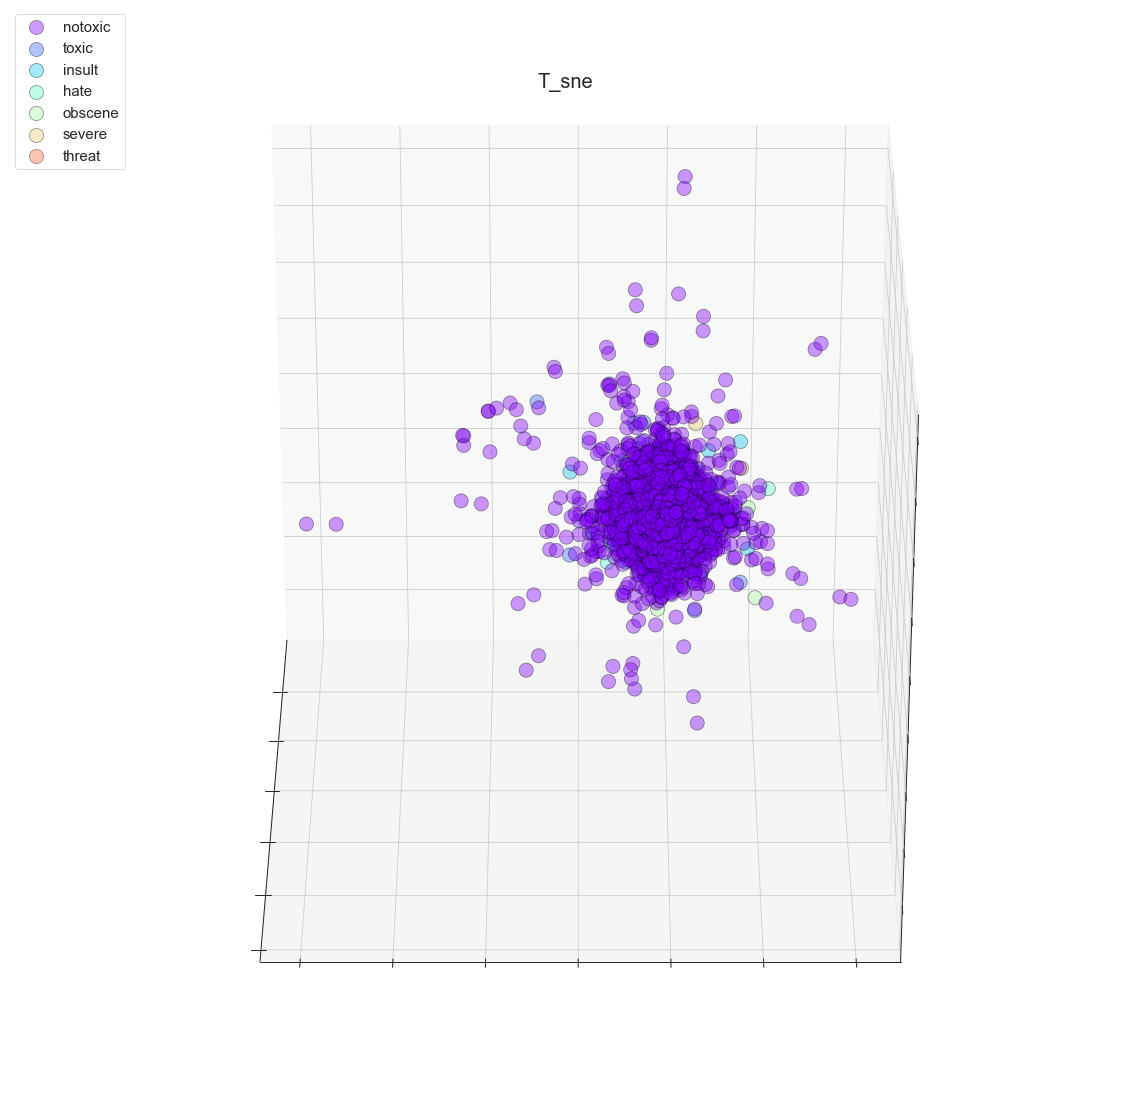

In [180]:
'''
VISUALIZATION 
11. DOC2VEC: Plot in 3D doc embeddings using tSNE
'''
plot_vectors(X_embedded, title = "T_sne", labels = tags_tsne, dimensions = 3, rot=180)

#### 3.2.2. Dimensionality Reduction SVD
<a id="doc2"></a>

**Justification:**  
We used SVD to reduce the dimensionality of our Doc2Vec output matrix, and to plot our document embeddings in 3D or 2D. As shown in the following graphs, there're overlaps between classes!

In [141]:
# SVD
sparse_input = train["lemmas_ex"].apply(str)
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words='english', analyzer='word', min_df=0.001, max_df=0.7, sublinear_tf=True, use_idf=True)
X = tfidf_vect.fit_transform(sparse_input)
terms = tfidf_vect.get_feature_names()
print(X.shape)

classes = np.array(train.classe.apply(str).tolist())
SVD = TruncatedSVD(n_components = 3)
U3 = SVD.fit_transform(X)

classes2 = np.array(train.negative.apply(str).tolist())

(94839, 3575)


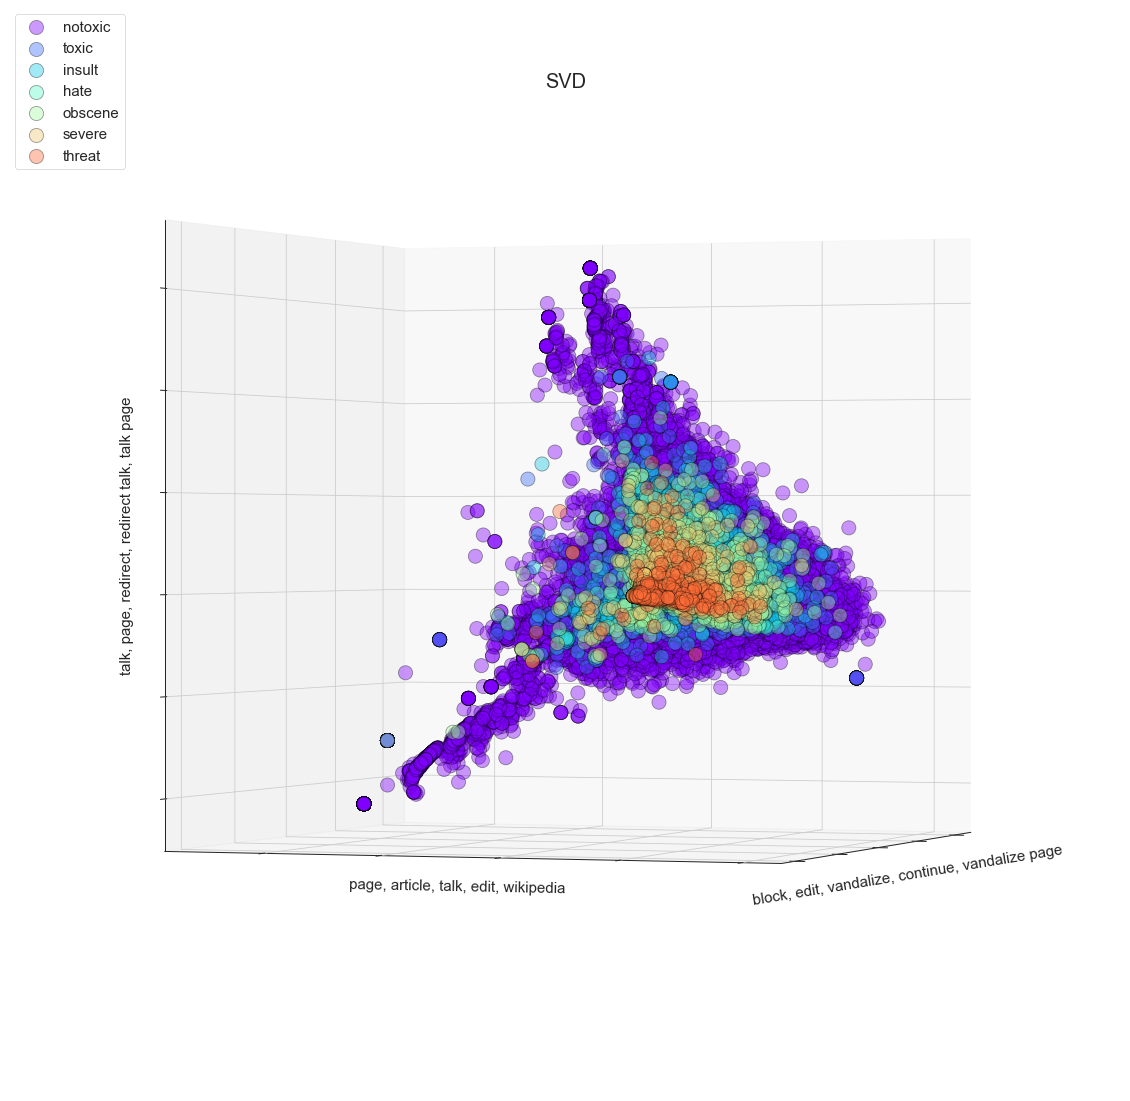

In [142]:
'''
VISUALIZATION 
12. SVD: Plot in 3D doc after dimensionality reduction with SVD, 7 classes as the number of toxic labels
'''
plot_vectors(U3, title = "SVD", labels = classes, dimensions = 3, low_dim = SVD, tfidf_feat_names=terms, rot=200)

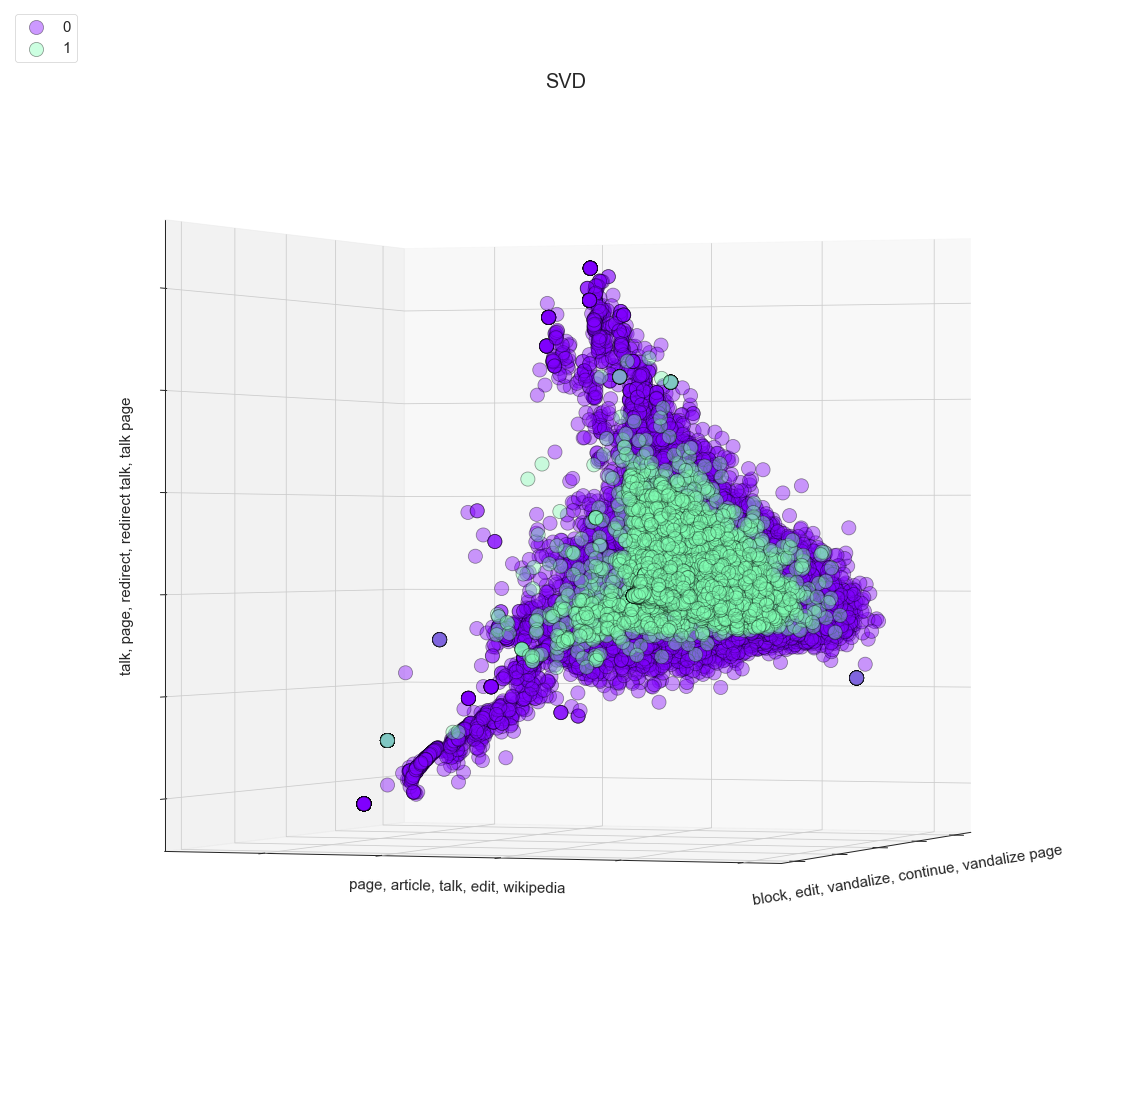

In [143]:
'''
VISUALIZATION 
13. SVD: Plot in 3D doc after dimensionality reduction with SVD, 2 classes, negative and not negative labels
'''
plot_vectors(U3, title = "SVD", labels = classes2, dimensions = 3, low_dim = SVD, tfidf_feat_names=terms, rot=200)

#### 3.2.3. KMeans Clustering 
<a id="doc3"></a>
**Justification:**  
We made 2 clusterings, the first with 7 groups, the number of toxic classes, the second with only 2 clusters that should correspond to our negative label. 

In [144]:
# CLUSTERING: 7 AS THE NUMBER OF CLASSES
k = 7
X7 = TruncatedSVD(n_components=100).fit_transform(X) #From 2711 to 100 latent dimensions
sample = np.random.choice(len(X7), replace=False, size=100)

# Agglomerative
agg = AgglomerativeClustering(n_clusters=k)
agg_sample_ids = agg.fit_predict(X7[sample])
centroids = np.array([X7[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

# KMeans
km = KMeans(n_clusters=k, n_jobs=-1, init=centroids)
km.fit(X7)
print(X7.shape)

(7, 100)


C:\Users\vince\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  


(94839, 100)


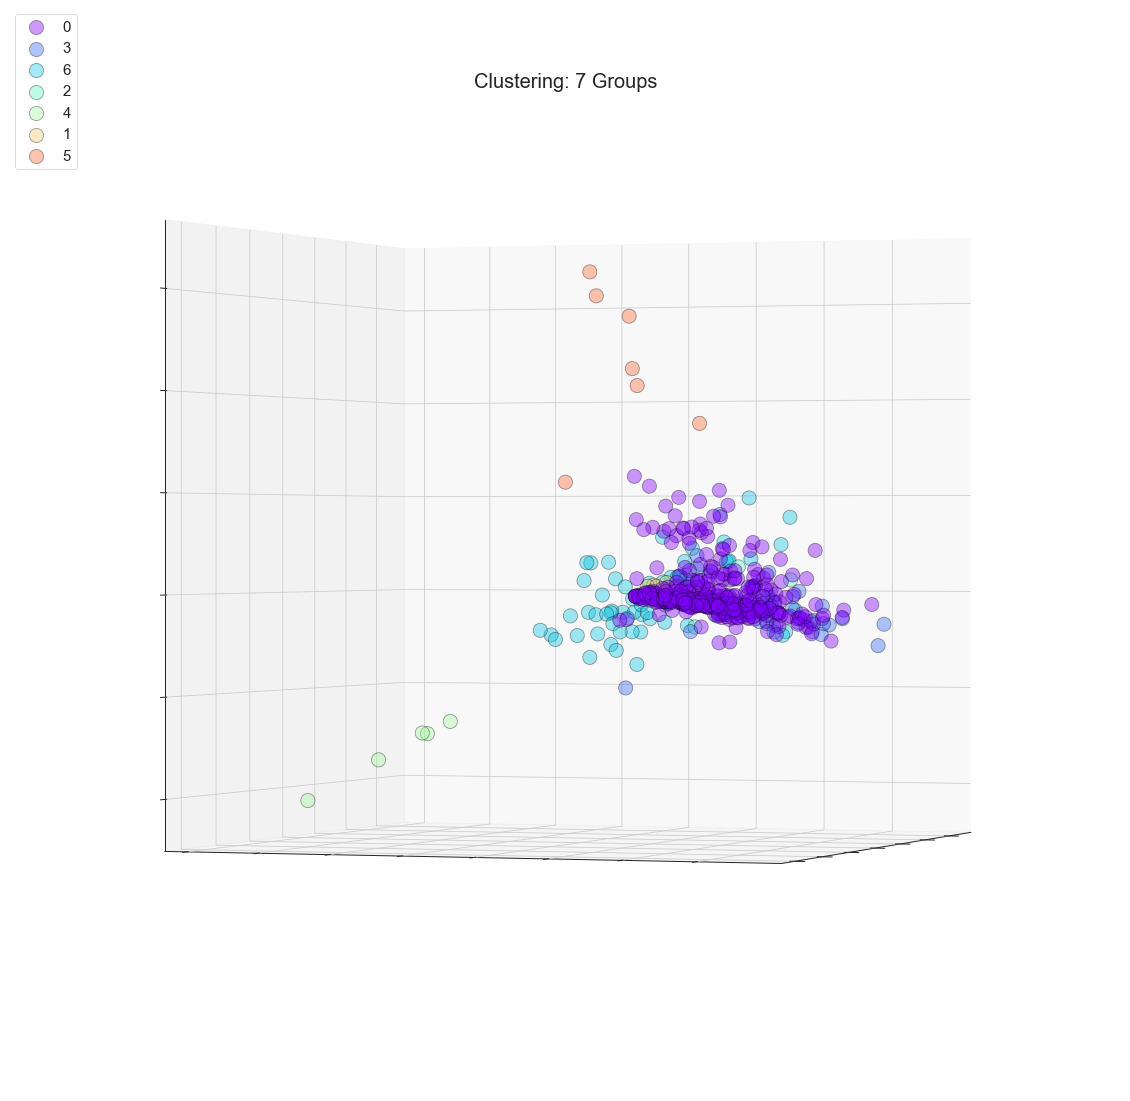

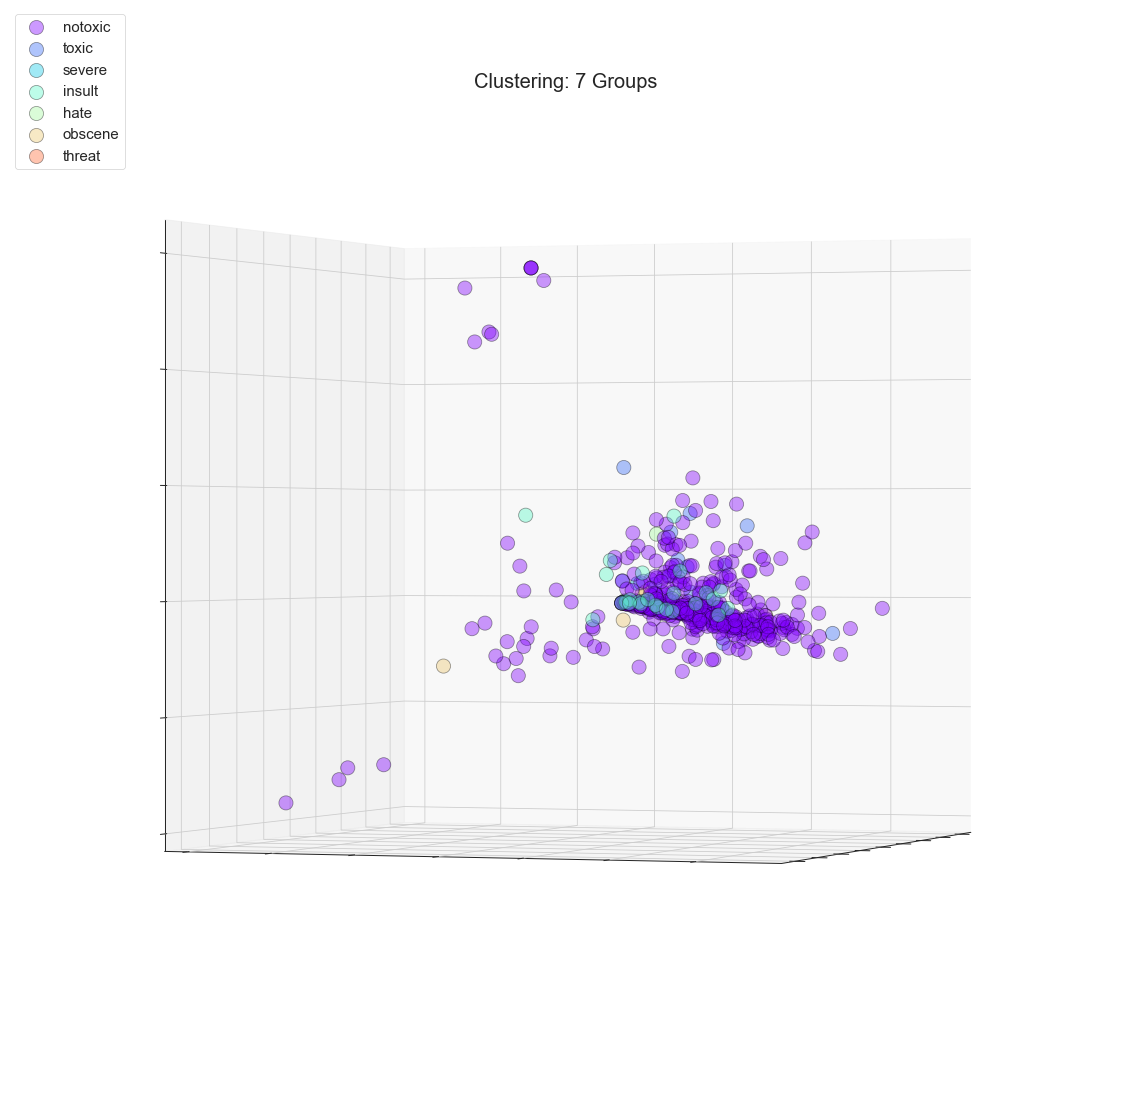

In [145]:
'''
VISUALIZATION
14. CLUSTERING: with 7 clusters
'''
# Plot Clustering with Kmeans 
plot_sample = np.random.choice(len(X7), replace=False, size=500)
plot_vectors(X7[plot_sample], title="Clustering: 7 Groups", labels=km.labels_[plot_sample], rot=200)

# Plot Clustering with SVD 
plot_sample = np.random.choice(len(X7), replace=False, size=500)
plot_vectors(X7[plot_sample], title="Clustering: 7 Groups", labels=classes[plot_sample], rot=200)

In [146]:
# CLUSTERING: 2 AS BINARY CLASSIFICATION (NEGATIVE OR NOT NEGATIVE)
k = 2
%time X2 = TruncatedSVD(n_components=100).fit_transform(X) #From 2711 to 100 latent dimensions
sample = np.random.choice(len(X2), replace=False, size=100)
agg = AgglomerativeClustering(n_clusters=k)
%time agg_sample_ids = agg.fit_predict(X2[sample])
centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

km = KMeans(n_clusters=k, n_jobs=-1, init=centroids)
%time km.fit(X2)
print(X2.shape)

Wall time: 3.97 s
Wall time: 2.18 ms
(2, 100)


C:\Users\vince\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  """Entry point for launching an IPython kernel.


Wall time: 1.09 s
(94839, 100)


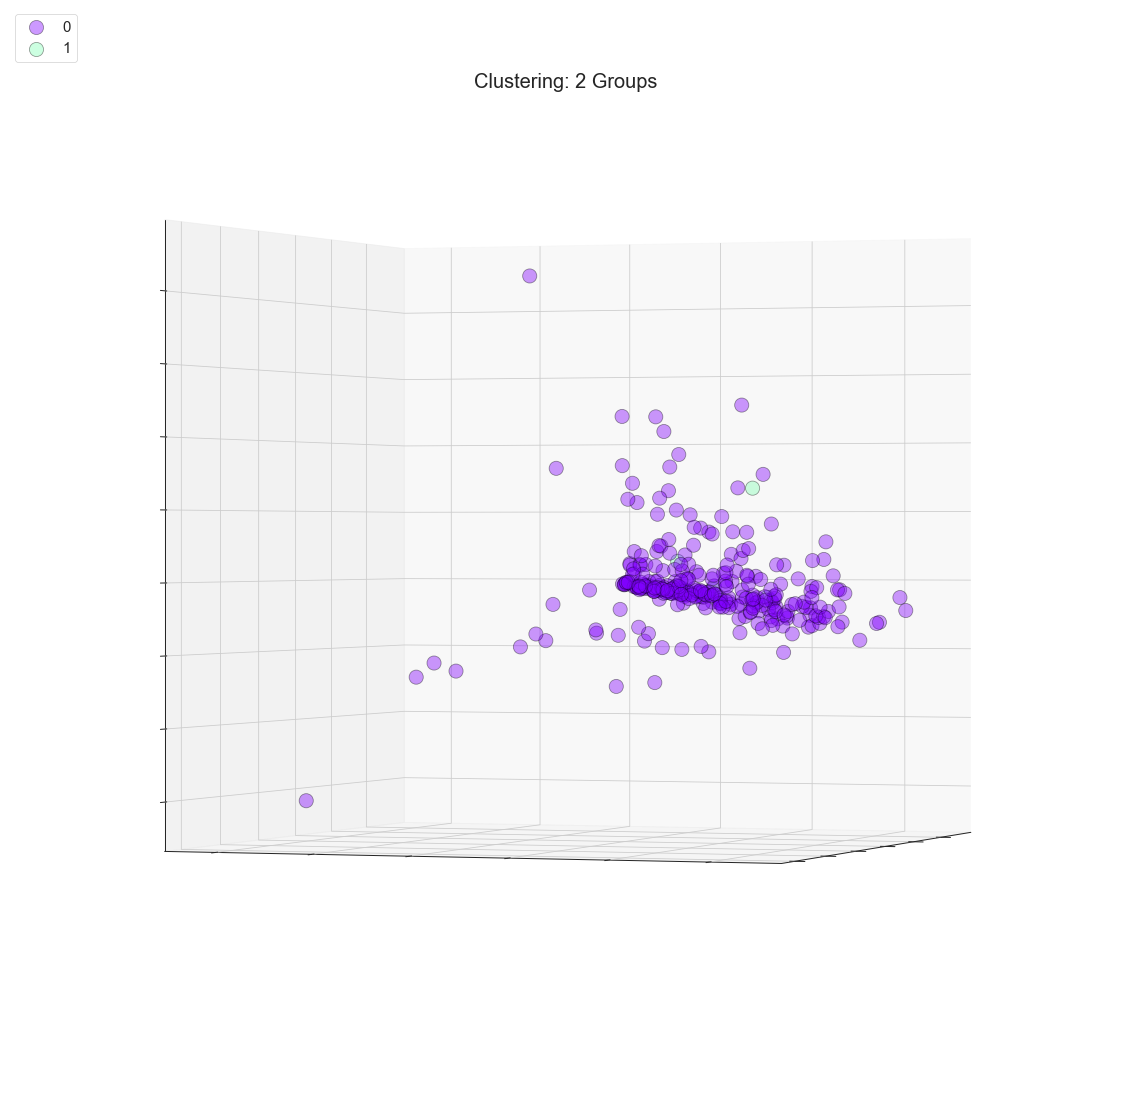

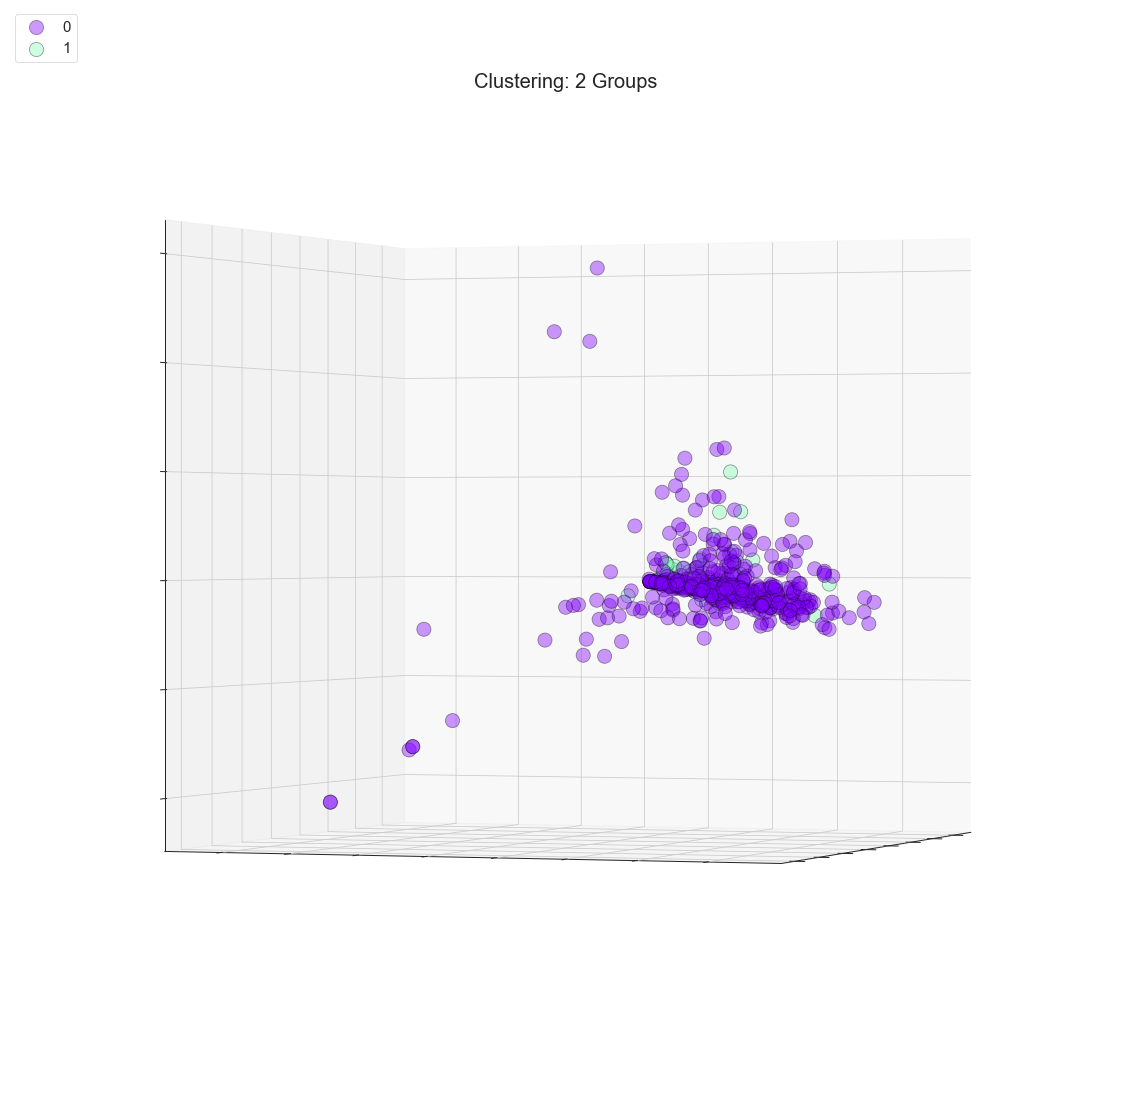

In [147]:
'''
VISUALIZATION
14. CLUSTERING: with 2 clusters (Negative and Not)
'''
# Plot Clustering with Kmeans 
plot_sample = np.random.choice(len(X2), replace=False, size=300)
plot_vectors(X2[plot_sample], title="Clustering: 2 Groups", labels=km.labels_[plot_sample], rot=200)

# Plot Clustering with SVD 
plot_sample = np.random.choice(len(X2), replace=False, size=500)
plot_vectors(X2[plot_sample], title="Clustering: 2 Groups", labels=classes2[plot_sample], rot=200)

### 3.3. Other methods
<a id="other"></a>
If appropriate for your problem, feel free to explore other methods, as long as they do not require additional libraries (**up to 2 bonus points**).

#### 3.3.1. TFIDF
<a id="tfidf"></a>

In [148]:
def tfidf(category, df=train, limit=10, grams=(1,1), lemma=True):
    '''
    Aim: Which are the most important (frequent) n-grams per category? 
    '''
    if category!=None:
        dc = df[df.classe.eq(category)]
    else: 
        dc = df

    if lemma == True:
        dc_corpus = dc.lemmas_ex.apply(str).tolist()
    else:
        dc_corpus = dc.tokens_ex.apply(str).tolist()

    # TFIDF 
    tfidf_vectorizer = TfidfVectorizer(analyzer='word',ngram_range=grams,min_df=0.001,max_df=0.75,sublinear_tf=True) 
    X = tfidf_vectorizer.fit_transform(dc_corpus)
    #print(X.shape)

    # TF 
    vectorizer = CountVectorizer(ngram_range=grams,analyzer='word',min_df=0.001,max_df=0.75)
    X1 = vectorizer.fit_transform(dc_corpus)
    #print(X1.shape)

    wfreq = pd.DataFrame(data={'word': vectorizer.get_feature_names(),'tf': X1.sum(axis=0).A1,
                               'idf': tfidf_vectorizer.idf_,'tfidf': X.sum(axis=0).A1})
    wfreq = wfreq.sort_values(['tfidf', 'tf', 'idf'], ascending=False).reset_index(drop=True)
    
    if limit!= None:
        return wfreq[:limit].reset_index(drop=True)
    else: 
        return wfreq

In [149]:
# WORD FREQUENCY - Train set
# Finding: comments are talking about Wikipedia pages 
train_df = tfidf(None,limit= None)  # dataframe with all unigrams,tf,idf,tfidf for the training set
train_df.head()

,word,tf,idf,tfidf
0,article,42987,2.461422,2960.502122
1,page,32569,2.636639,2751.231506
2,talk,23140,2.733912,2739.176526
3,edit,21140,2.977444,2183.366807
4,wikipedia,26692,2.836901,2078.485423


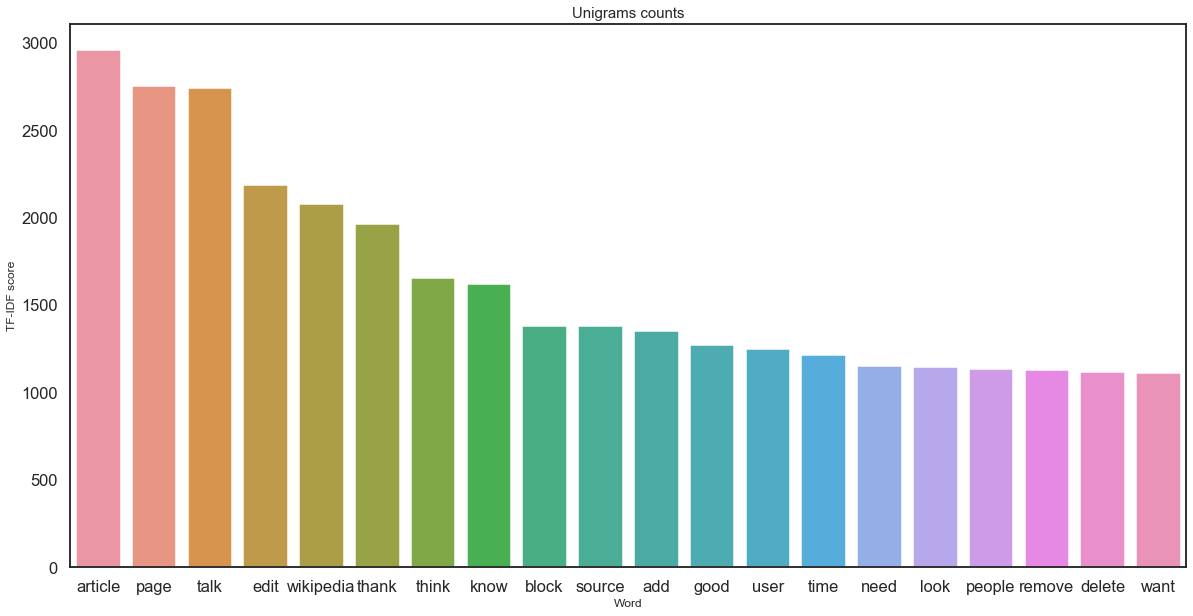

In [150]:
'''
VISUALIZATION
15. UNIGRAMS: Plot the 20 most frequent unigrams in the training set
'''
train_df = train_df[:20] 
sns.set_context("talk")
fig, axis = plt.subplots(figsize = (20, 10))
sns.barplot(train_df['word'],train_df['tfidf'], ax= axis)
plt.title("Unigrams counts",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [151]:
# Visualization for only negative comments
train_df_neg = tfidf(None,df=train[train["negative"]==1])  # dataframe with all unigrams,tf,idf,tfidf for the training set
train_df_neg.head()

,word,tf,idf,tfidf
0,fuck,6678,2.799501,423.366056
1,page,1723,3.110343,213.330672
2,fucking,1649,3.429765,210.878088
3,wikipedia,2258,3.082364,202.019757
4,suck,2449,3.842952,186.582523


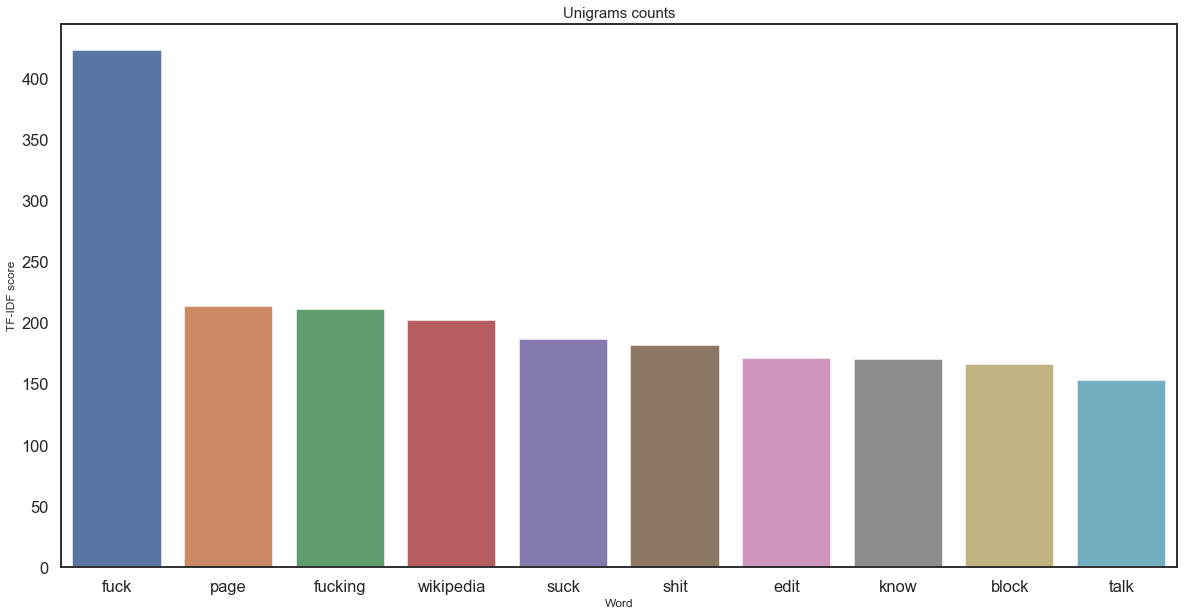

In [152]:
'''
VISUALIZATION
16. UNIGRAMS: Plot the 20 most frequent unigrams in the negative training set
'''
train_df_neg = train_df_neg[:20] 
sns.set_context("talk")
fig, axis = plt.subplots(figsize = (20, 10))
sns.barplot(train_df_neg['word'],train_df_neg['tfidf'], ax= axis)
plt.title("Unigrams counts",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)
plt.show()

In [153]:
# WORD FREQUENCY - Train set per classe label 
# Finding: toxic comments are really toxic 
df_cat = pd.DataFrame()
for i in classe: 
    a = tfidf(i, limit=5, grams=(2,2)).reset_index().drop(['index'],axis=1)
    a["category"] = i.upper()
    df_cat = df_cat.append(a, ignore_index=True)
df_cat

,word,tf,idf,tfidf,category
0,talk page,81,4.147359,17.017335,OBSCENE
1,personal attack,30,4.860309,10.341512,OBSCENE
2,fuck fuck,44,5.514235,7.137414,OBSCENE
3,piece shit,12,5.514235,6.914098,OBSCENE
4,suck cock,6,6.133274,5.675612,OBSCENE
5,talk page,100,4.627128,44.627479,INSULT
6,piece shit,64,4.987130,41.571522,INSULT
7,personal attack,47,5.367903,28.185880,INSULT
8,suck dick,203,5.680278,23.909960,INSULT
9,son bitch,35,5.555115,22.978872,INSULT


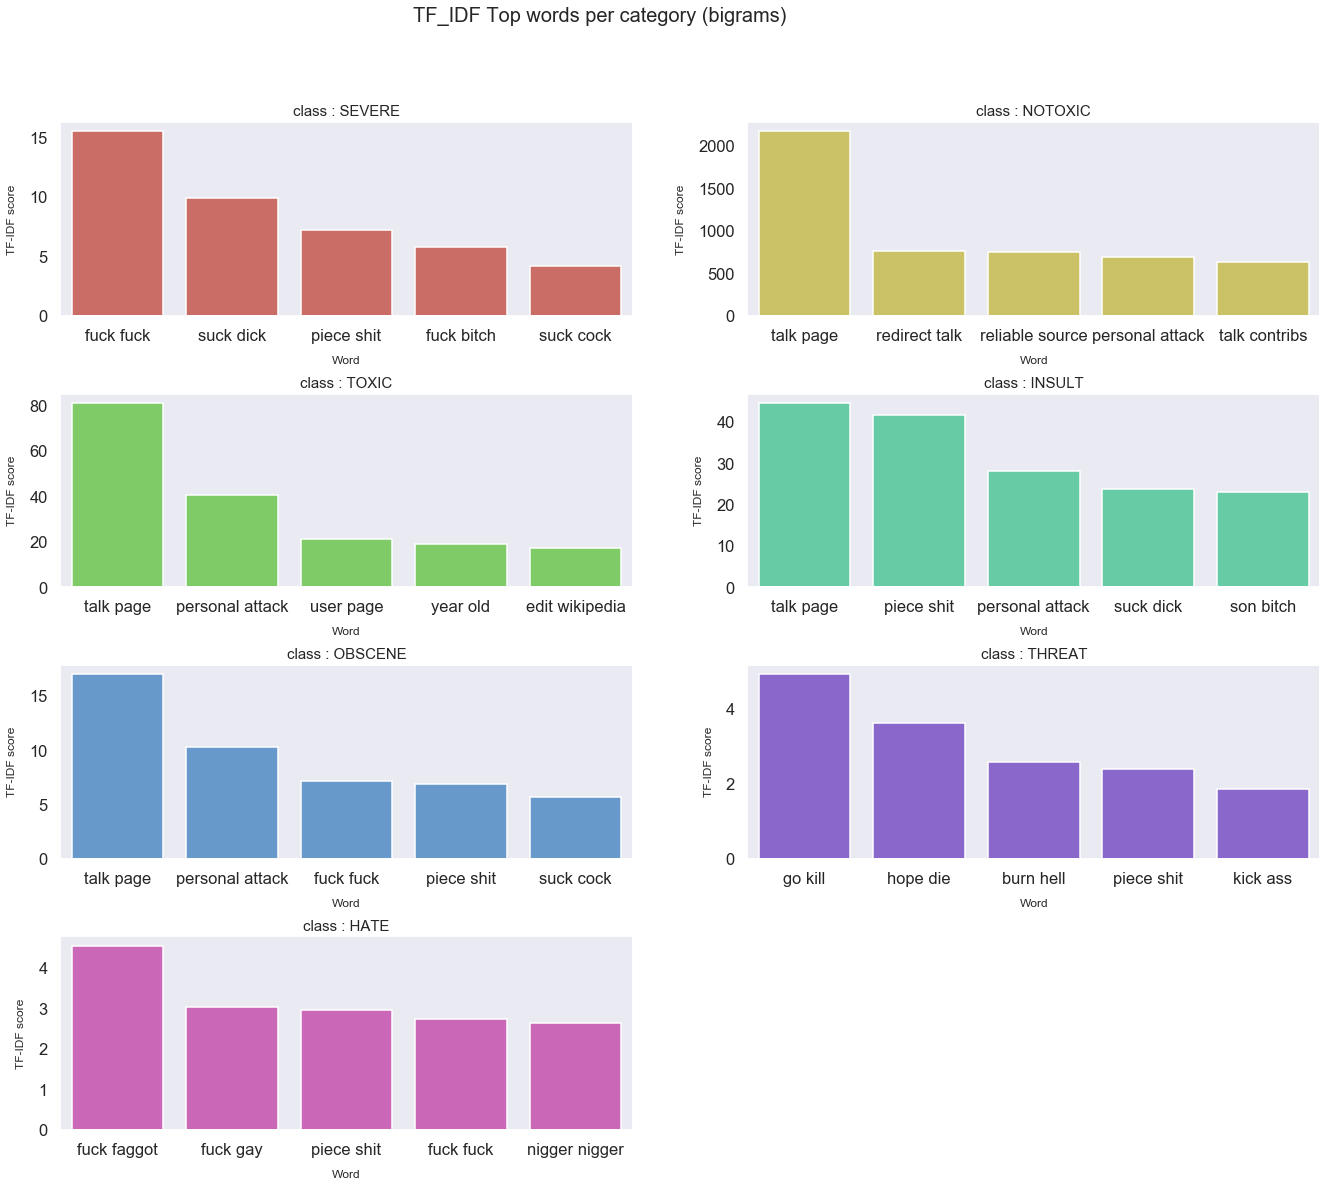

In [154]:
'''
VISUALIZATION
17. TFIDF: Plot frequency of most common bigrams per category
''' 
color = sns.color_palette("hls", 7)
sns.set_style("dark")
plt.figure(figsize=(20,20))
plt.suptitle("TF_IDF Top words per category (bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplots_adjust(bottom=0.2, right=1, top=0.9, hspace=0.4)

cat = list(set(df_cat.category.tolist()))
subplots = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0)]

for i in range(len(cat)): 
    plt.subplot2grid((4,2),subplots[i])
    wf = df_cat[df_cat['category']== cat[i]]
    sns.barplot(wf['word'],wf['tfidf'],color=color[i])
    plt.title("class : {}".format(cat[i]),fontsize=15)
    plt.xlabel('Word', fontsize=12, labelpad=12)
    plt.ylabel('TF-IDF score', fontsize=12,labelpad=12)

#### 3.3.2. NER
<a id="ner"></a>
Which Nationality or religion or political group (NORP) are mainly addressed in these toxic comments? 

(NB: run on a small subset of train because it's super slow) 

In [163]:
ner = train
documents = ner['txt_expanded'].to_list()
entities = [(entity.text, entity.label_) for sentence in documents for entity in nlp(sentence).ents if entity.label_ == 'NORP']
c = Counter(entities)
c.most_common(5)

[(('american', 'NORP'), 1183),
 (('british', 'NORP'), 1057),
 (('jewish', 'NORP'), 940),
 (('german', 'NORP'), 744),
 (('jews', 'NORP'), 726)]

In [164]:
negat_train = train[train.negative == 1]
documents = negat_train['txt_expanded'].to_list()
entities_neg = [(entity.text, entity.label_) for sentence in documents for entity in nlp(sentence).ents if entity.label_ == 'NORP']
c = Counter(entities_neg)
c.most_common(5)

[(('jewish', 'NORP'), 272),
 (('jews', 'NORP'), 189),
 (('idiot', 'NORP'), 121),
 (('nazi', 'NORP'), 113),
 (('american', 'NORP'), 86)]